# Test GEModelTools - HANK

This notebook shows how to **solve a simple Heterogenous Agent New Keynessian (HANK) model** using the `GEModelTools` package.

**The steps of the sequence-space solution method are:**

1. Find the stationary equilibrium (steady state for aggregates and distribution).
2. Compute Jacobians of the household block and the full model (to unknowns and shocks)
3. Find the non-linear transition path or the linearized impulse responses to a given shock path.
4. Simulate the linearized model with aggregate risk

# Imports

In [148]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
import sys
from scipy import optimize

import matplotlib.pyplot as plt   
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
#np.set_printoptions(threshold=sys.maxsize)

from HANKmodel import HANKModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup

In [149]:
#print(model)
model = HANKModelClass(name='baseline')
#model.print_unpack_varlist()

In [150]:
#model = HANKModelClass(name='baseline')
#model.find_ss(do_print=False)
#par = model.par
#ss = model.ss
#path = model.path
#sim = model.sim
#model.test_hh_path()
#model.compute_jacs(do_print=False)
#par.jump_istar = 0.0 # MP shock removed
#par.jump_pm_N     = 0.01*ss.Q # cost push shock
#model.find_transition_path(do_print=False) #all
#paths = ['pm_N','pi_L','pi_N','p_N','p_L','P_hh','P','Q','Q_check'] #Show all graphs
#lvl_value = ['i','pi_L','pi_N','r','pi','tau','Q','Q_check','P_hh'] #Show all push
#model.show_IRFs(paths,lvl_value=lvl_value,T_max=20,ncols=4)

# Step 1: Steady state

In [151]:
model.find_ss(do_print=True)

steady state found in 23.5 secs
 Q   =   0.7235
 P   =   0.8136
 Z_N   =   0.2591
 Z_L   =   0.9977
 M_N   =   0.3121
 M_L   =   0.1242
 N_L   =   0.4029
 N_N   =   0.5469
 HH_ell   =   1.1301
 wage N  =   0.2757
 wage L  =   0.3811
 par.varphi   =   1.0000
 par.beta   =   0.9716
Discrepancy in B =   0.00000000
Discrepancy in C =   0.00000000
Discrepancy in C_L =   0.00000000
Discrepancy in C_N =   0.00000000
Discrepancy in N =  -0.00000000


In [152]:
par = model.par
ss = model.ss
path = model.path
sim = model.sim

Distribution graphs:

In [153]:
print(f'Average expenditures share on luxuries (in the data = 51.8%) = {(ss.C_L*ss.Q/(ss.P*ss.C)):8.4f}')
print(f'Average Subsistence share of expenditures (in the data = 22.4%) = {(par.c_bar/(ss.P*ss.C)):8.4f}')
print(f'Lowest income household subsistence share of expenditures (in the data = 43,5%) = {(par.c_bar/(ss.P*np.average(ss.c[0,0,0]))):8.4f}')
print(f'Average expenditures share on necessities for the lowest income households (in the data = 70.5%): = {(np.average(ss.c_N[0,0,0]))/(ss.P*np.average(ss.c[0,0,0])):8.4f}')
print(f'Average expenditures share on necessities (in the data = 48.2%) = {(ss.C_N/(ss.P*ss.C)):8.4f}')
print(f'Average expenditures share on necessities, net of subsistence (in the data = 33.2%) = {(ss.C_HAT_N_hh/(ss.P*ss.C)):8.4f}')
print(f'wage share, necessities production: (in the data = 37.3%) = {(ss.N_N*ss.w_N/(ss.M_N*ss.pm_N+ss.N_N*ss.w_N)):8.4f}')
print(f'wage share, luxuries production: (in the data =69.2%) = {(ss.N_L*ss.w_L/(ss.M_L*ss.pm_L+ss.N_L*ss.w_L)):8.4f}')

Average expenditures share on luxuries (in the data = 51.8%) =   0.5459
Average Subsistence share of expenditures (in the data = 22.4%) =   0.1004
Lowest income household subsistence share of expenditures (in the data = 43,5%) =   0.4974
Average expenditures share on necessities for the lowest income households (in the data = 70.5%): =   0.6950
Average expenditures share on necessities (in the data = 48.2%) =   0.4541
Average expenditures share on necessities, net of subsistence (in the data = 33.2%) =   0.3537
wage share, necessities production: (in the data = 37.3%) =   0.4004
wage share, luxuries production: (in the data =69.2%) =   0.5528


Text(0, 0.5, '$c_{L,t}$')

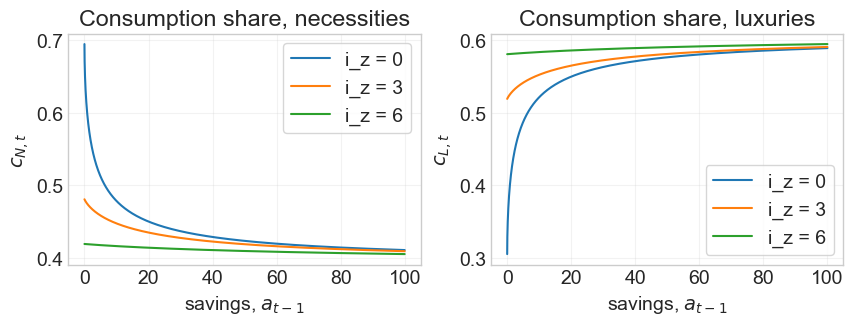

In [154]:
fig = plt.figure(figsize=(10,3),dpi=100)
a_max = 500

# a. necessity consumption share
I = par.a_grid < a_max

ax = fig.add_subplot(1,2,1)
ax.set_title(f'Consumption share, necessities')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.c_N[0,i_z,I]/(ss.P*ss.c[0,i_z,I]),label=f'i_z = {i_z}')

ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('$c_{N,t}$')

# a. luxury consumption share
I = par.a_grid < a_max

ax = fig.add_subplot(1,2,2)
ax.set_title(f'Consumption share, luxuries')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.Q*ss.c_L[0,i_z,I]/(ss.P*ss.c[0,i_z,I]),label=f'i_z = {i_z}')

ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('$c_{L,t}$')

Marginal propensities to consume

mean MPC: 0.074 [annual: 0.265]


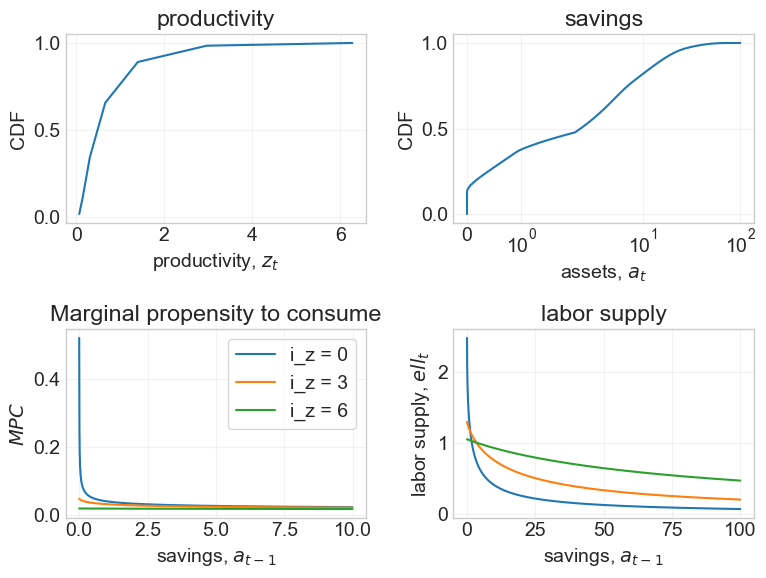

In [155]:
MPC = np.zeros(ss.D.shape)
m_diff = (1+ss.r)*par.a_grid[np.newaxis,np.newaxis,1:]-(1+model.ss.r)*par.a_grid[np.newaxis,np.newaxis,:-1]
MPC[:,:,:-1] = (ss.c[:,:,1:]-ss.c[:,:,:-1])/m_diff
MPC[:,:,-1] = MPC[:,:,-1] # assuming constant MPC at end
mean_MPC = np.sum(MPC*ss.D)
mean_MPC_ann = 1-(1-mean_MPC)**4
print(f'mean MPC: {mean_MPC:.3f} [annual: {mean_MPC_ann:.3f}]')

fig = plt.figure(figsize=(8,6),dpi=100)

# a. income
ax = fig.add_subplot(2,2,1)
ax.set_title('productivity')

y = np.cumsum(np.sum(ss.D[0],axis=1))
ax.plot(par.z_grid,y/y[-1])

ax.set_xlabel('productivity, $z_{t}$')
ax.set_ylabel('CDF')

# b. assets
ax = fig.add_subplot(2,2,2)
ax.set_title('savings')
y = np.insert(np.cumsum(np.sum(ss.D[0],axis=0)),0,0.0)
ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),y/y[-1])
        
ax.set_xlabel('assets, $a_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog')

# c. MPC
I = par.a_grid < 10

ax = fig.add_subplot(2,2,3)
ax.set_title(f'Marginal propensity to consume')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],MPC[0,i_z,I],label=f'i_z = {i_z}')
ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('$MPC$')


# D. labor supply
I = par.a_grid < a_max

ax = fig.add_subplot(2,2,4)
ax.set_title(f'labor supply')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.ell[0,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('labor supply, $ell_{t}$')

fig.tight_layout()

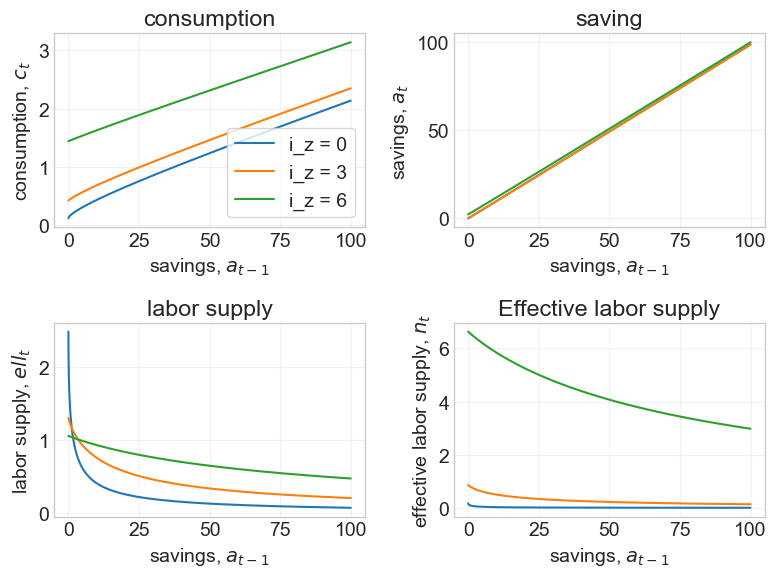

In [156]:
fig = plt.figure(figsize=(8,6),dpi=100)
a_max = 500

# a. consumption
I = par.a_grid < a_max

ax = fig.add_subplot(2,2,1)
ax.set_title(f'consumption')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.c[0,i_z,I],label=f'i_z = {i_z}')

ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('consumption, $c_t$')

# b. saving
I = par.a_grid < a_max

ax = fig.add_subplot(2,2,2)
ax.set_title(f'saving')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.a[0,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('savings, $a_{t}$')

# c. labor supply
I = par.a_grid < a_max

ax = fig.add_subplot(2,2,3)
ax.set_title(f'labor supply')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.ell[0,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('labor supply, $ell_{t}$')


# c. labor supply
I = par.a_grid < a_max

ax = fig.add_subplot(2,2,4)
ax.set_title(f'Effective labor supply')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.n[0,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('effective labor supply, $n_{t}$')

fig.tight_layout()

# Step 2: Compute Jacobians (incl. tests)

**Household transition path:**

note: inputs = steady state value -> expected: constant value (straigt line)

household problem solved along transition path in 5.8 secs
household problem simulated along transition in 2.7 secs



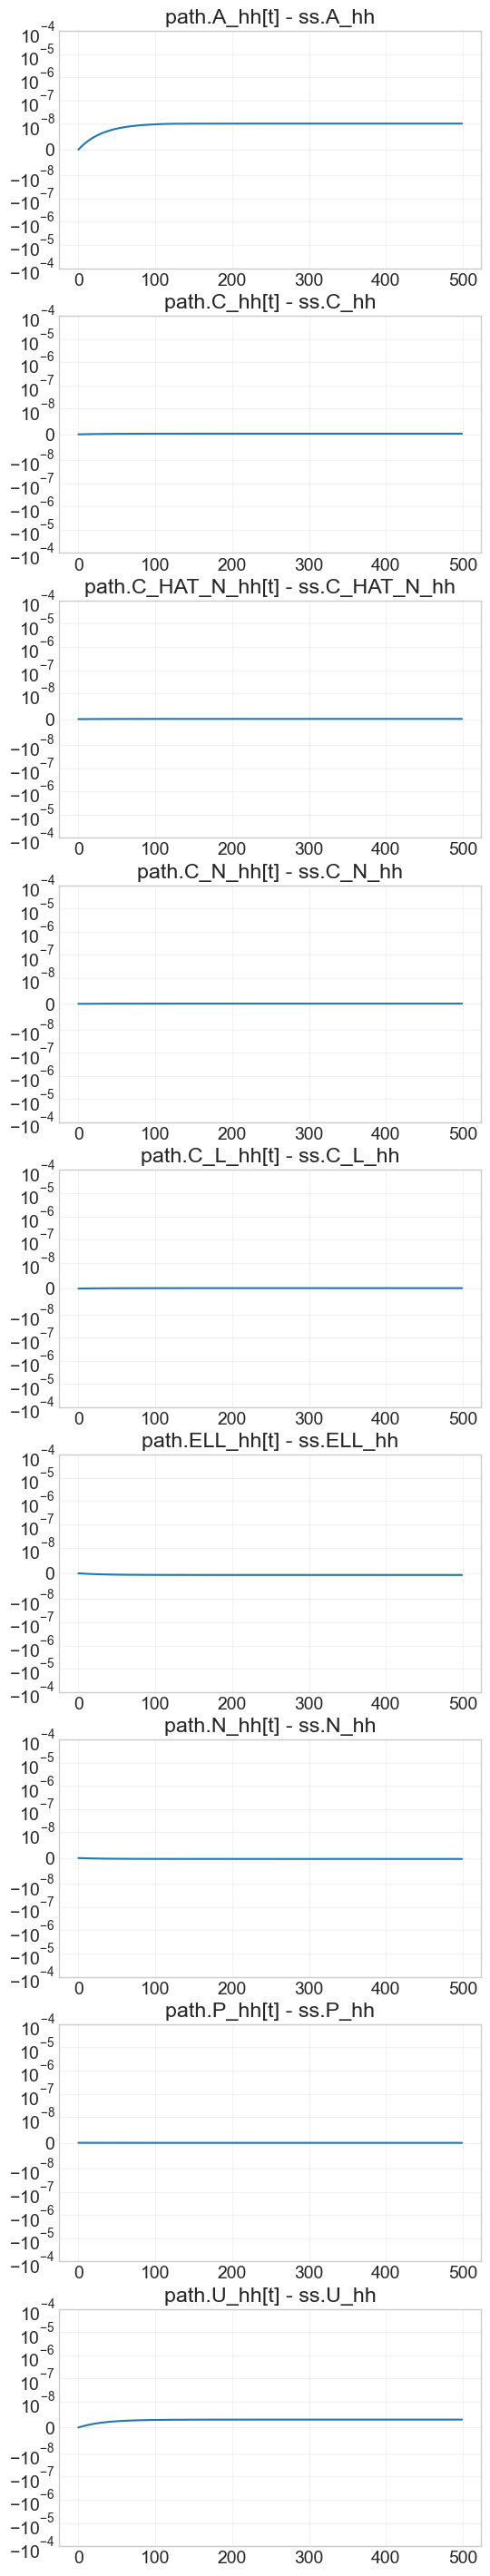

In [157]:
model.test_hh_path()

**Full transition path:**

In [158]:
model.test_path()

note: inputs = steady state value -> expected: no difference to steady state and zero errors

difference to value at steady state:
A              : t0 =  0.0e+00, max abs.  0.0e+00
B              : t0 =  0.0e+00, max abs.  0.0e+00
C              : t0 =  0.0e+00, max abs.  0.0e+00
C_N            : t0 =  0.0e+00, max abs.  0.0e+00
C_L            : t0 =  0.0e+00, max abs.  0.0e+00
d_N            : t0 =  0.0e+00, max abs.  0.0e+00
d_L            : t0 =  0.0e+00, max abs.  0.0e+00
G              : t0 = -6.9e-18, max abs.  6.9e-18
i              : t0 =  0.0e+00, max abs.  0.0e+00
N              : t0 =  0.0e+00, max abs.  0.0e+00
N_N            : t0 =  0.0e+00, max abs.  0.0e+00
N_L            : t0 =  0.0e+00, max abs.  0.0e+00
M_N            : t0 =  0.0e+00, max abs.  0.0e+00
M_L            : t0 =  0.0e+00, max abs.  0.0e+00
pm_L           : t0 =  0.0e+00, max abs.  0.0e+00
pm_N           : t0 =  0.0e+00, max abs.  0.0e+00
p_N            : t0 =  0.0e+00, max abs.  0.0e+00
p_L            : t0

In [159]:
model.compute_jacs(do_print=True)
#model.test_jacs(s_list=[50,100,150])

household Jacobians:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for P               in 1.1 secs
curly_Y and curly_D calculated for Q               in 1.5 secs
curly_Y and curly_D calculated for d_L             in 1.3 secs
curly_Y and curly_D calculated for d_N             in 1.6 secs
curly_Y and curly_D calculated for p_L             in 1.4 secs
curly_Y and curly_D calculated for p_N             in 1.6 secs
curly_Y and curly_D calculated for r               in 1.2 secs
curly_Y and curly_D calculated for tau             in 1.5 secs
curly_Y and curly_D calculated for w_N             in 1.2 secs
curly_E calculated in 0.9 secs
builiding blocks combined in 1.7 secs
household Jacobian computed in 14.9 secs

full Jacobians:
full Jacobian to unknowns computed in 8.9 secs [in evaluate_path(): 5.4 secs]
full Jacobian to shocks computed in 4.9 secs [in evaluate_path(): 3.7 secs]


# Step 3a: Find non-linear transition path

## Plot transitions

## Find transition path 1 - cost push shock

In [178]:
par.jump_istar = 0.0 # MP shock removed
par.jump_pm_N     = 0.01*ss.Q # cost push shock
model.find_transition_path(do_print=False) #all
paths = ['pm_N','P_hh','r','pi_L','pi_N','Q','C_N','C_L','N_N','N_L','M_N','M_L','w_N','d_N','d_L'] #Show all graphs
paths_prices = ['pm_N','P_hh','r','pi_L','pi_N','Q'] #Show pricing graphs
paths_hh =['C_N','C_L','N_N','N_L','M_N','M_L','w_N','d_N','d_L']
lvl_value = ['i','pi_L','pi_N','r','pi','tau'] #Show all push

### shocks ###


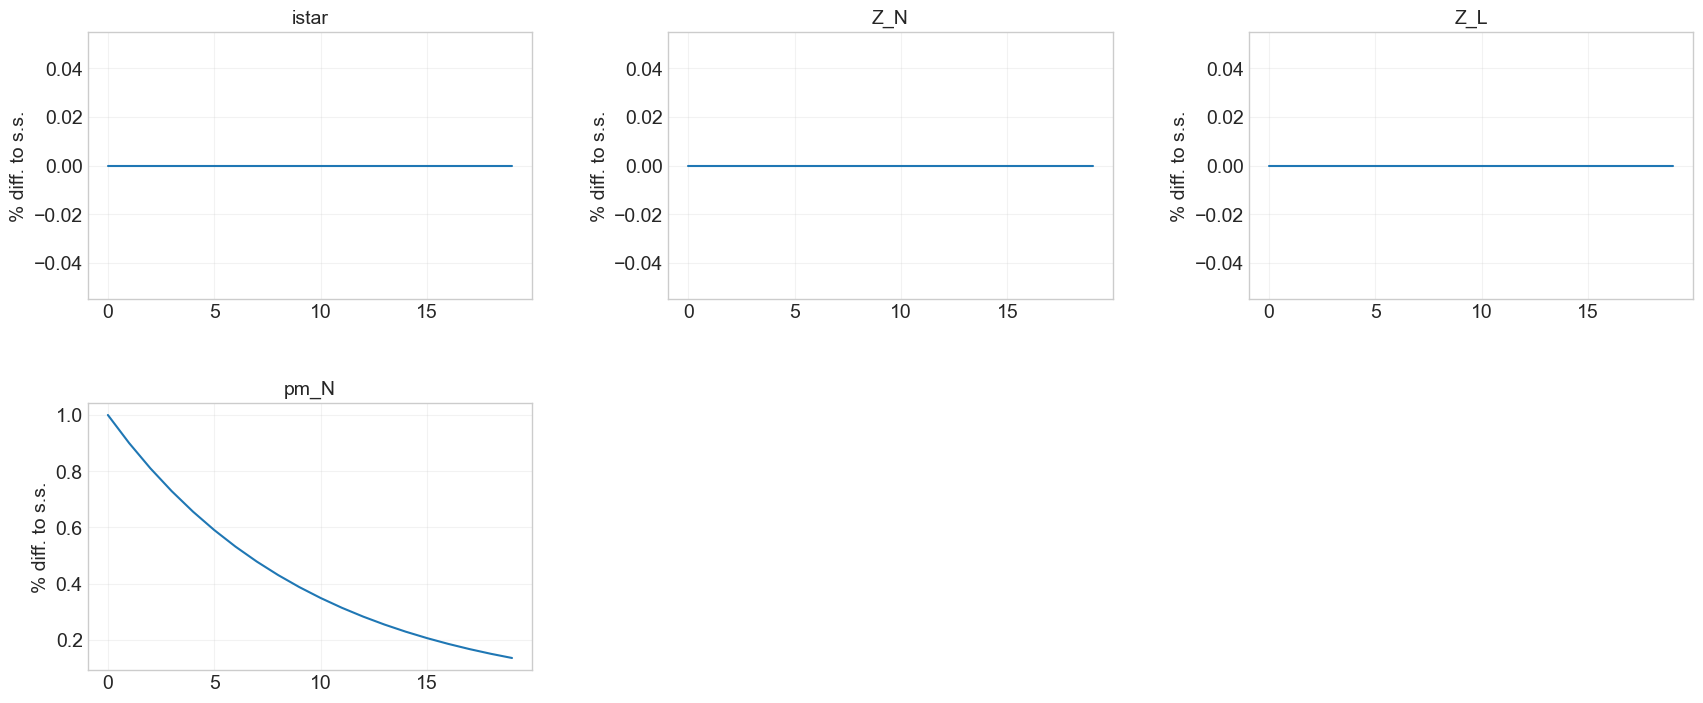


### varnames ###


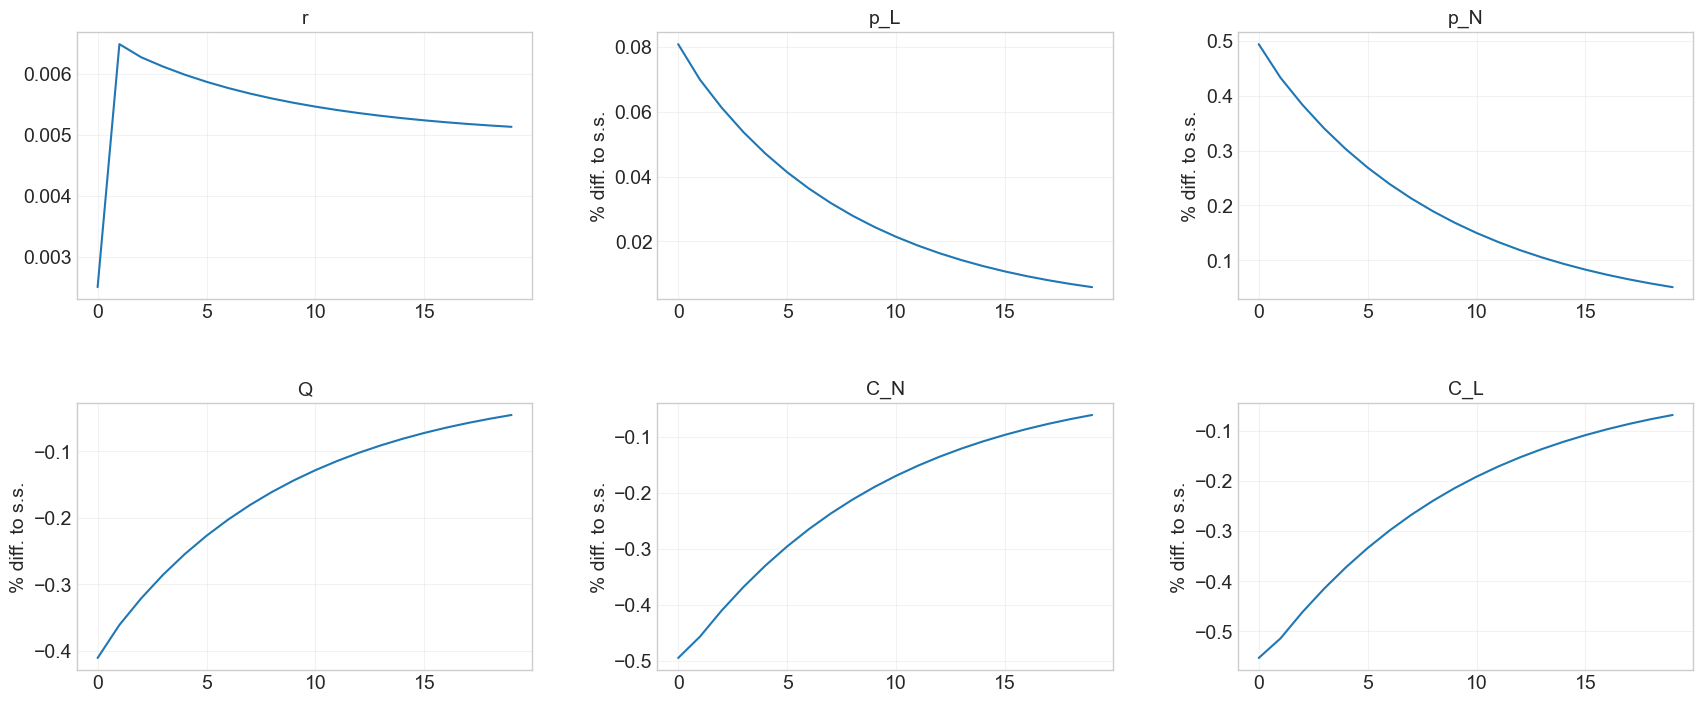


### tagets ###


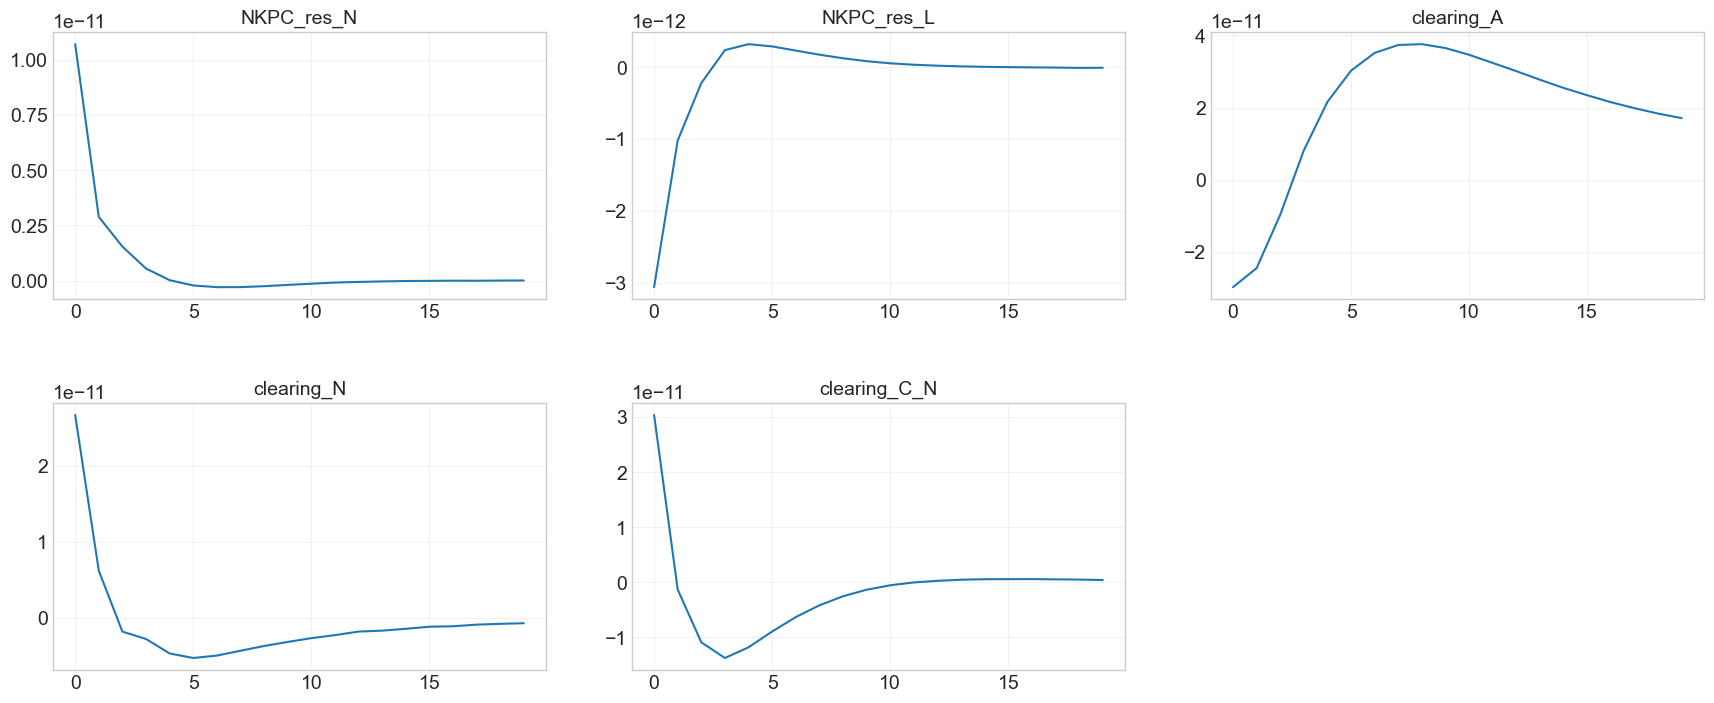

In [179]:
paths_main = ['r','p_L','p_N','Q','C_N','C_L'] #Show main
model.show_IRFs(paths_main,lvl_value=lvl_value,T_max=20,ncols=3)

### shocks ###


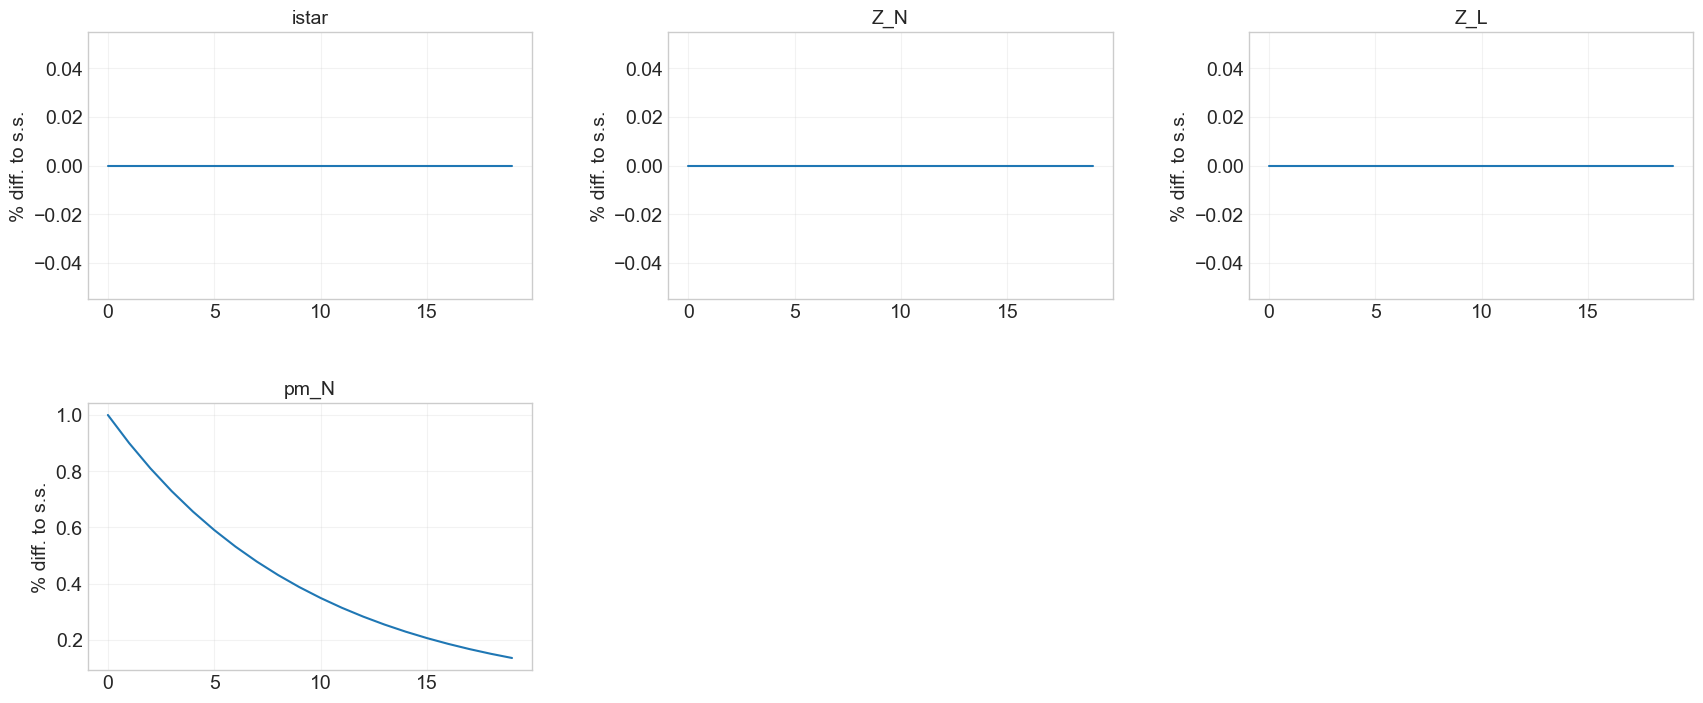


### varnames ###


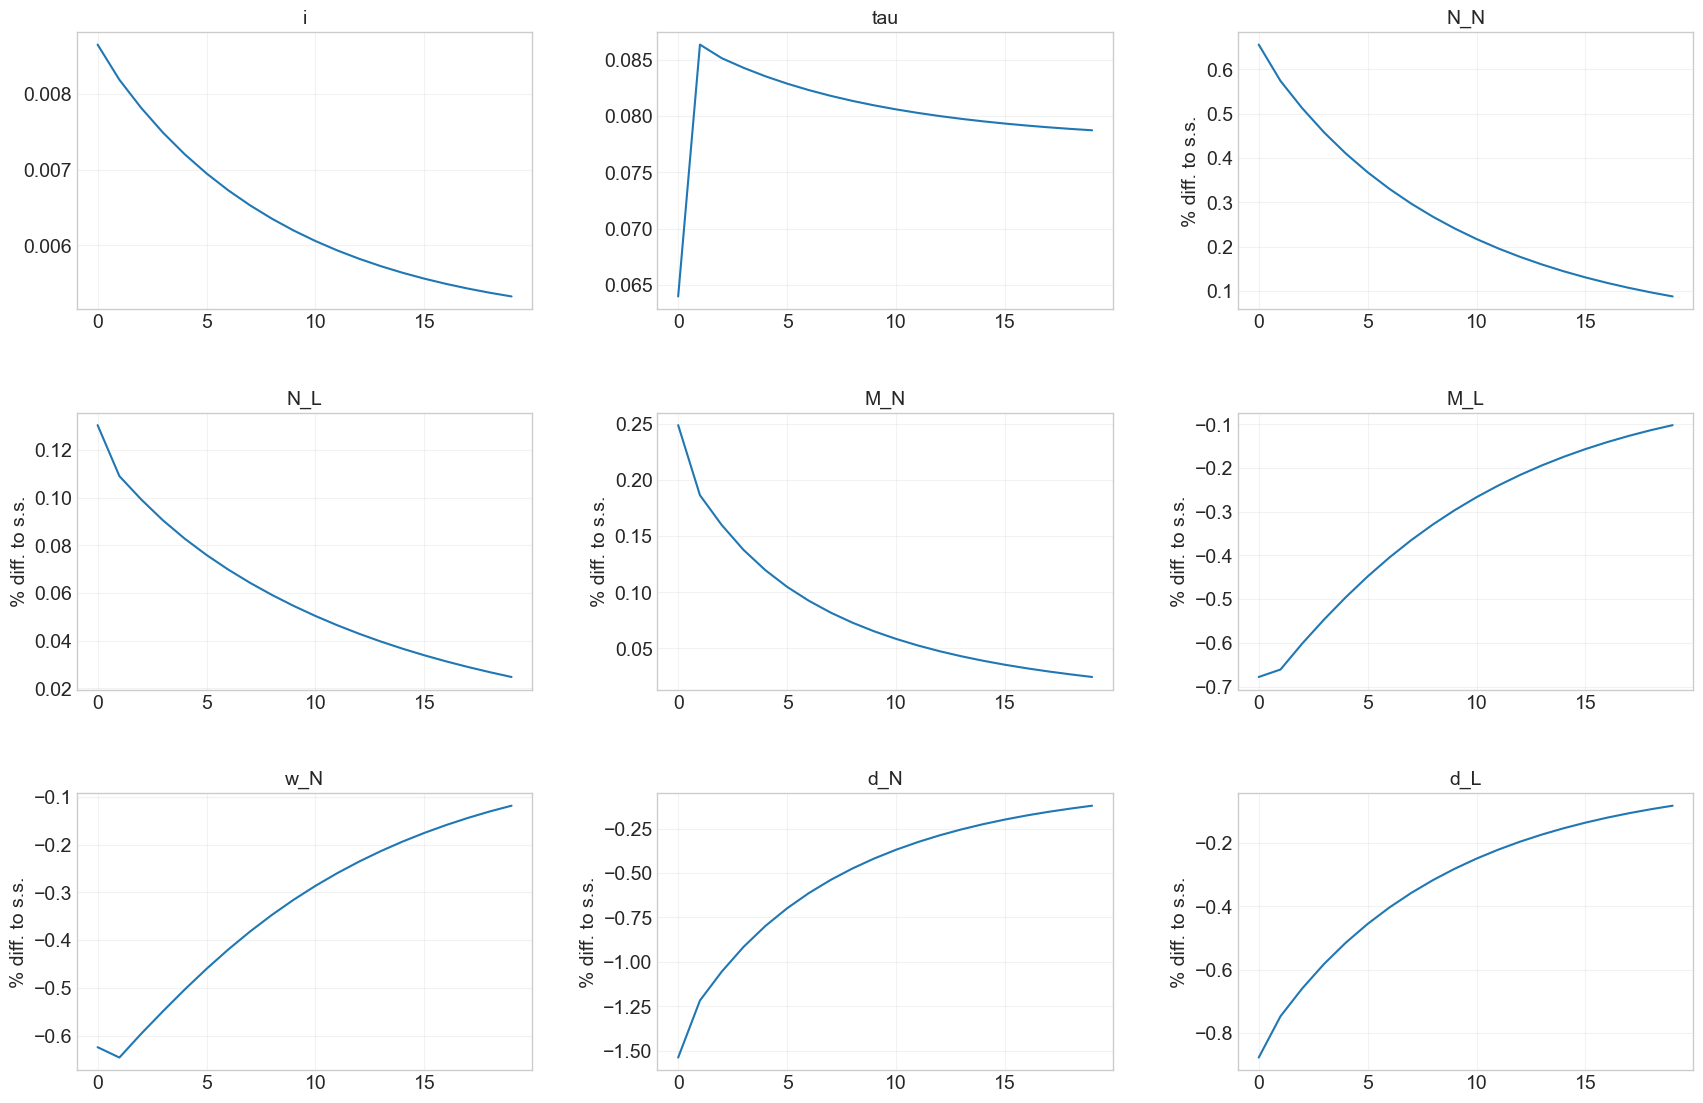


### tagets ###


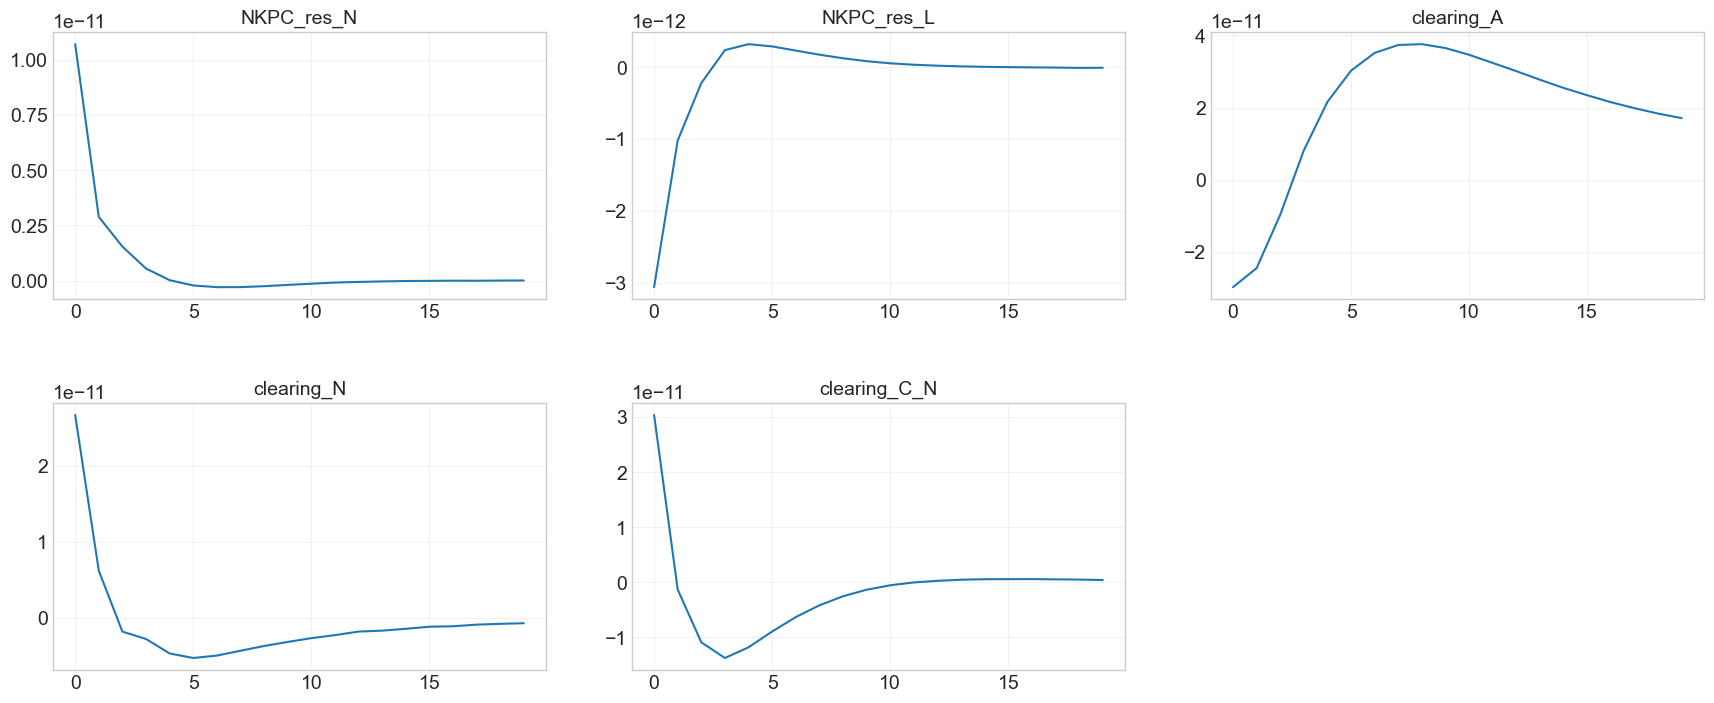

In [180]:
paths_appendix = ['i','tau','N_N','N_L','M_N','M_L','w_N','d_N','d_L'] #Show appendix
model.show_IRFs(paths_appendix,lvl_value=lvl_value,T_max=20,ncols=3)

Consumption decomposition, cost push shock

['r']

['price effects', 'Q', 'P', 'p_L', 'p_N']

['income effects', 'N', 'w_N', 'd_N', 'd_L', 'tau']

None

all

['r']

['Q', 'P', 'p_L', 'p_N']

['N', 'w_N', 'd_N', 'd_L', 'tau']

None

all



Text(0, 0.5, '% diff to s.s.')

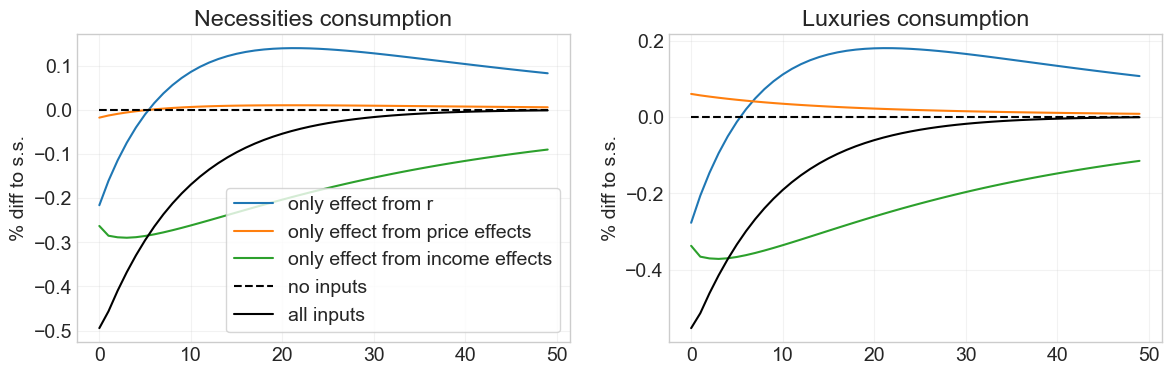

In [181]:
T_max = 50

fig = plt.figure(figsize=(14,4),dpi=100)

ax = fig.add_subplot(1,2,1)
i_color = 0
for use_inputs in [['r'],['price effects','Q','P','p_L','p_N'],['income effects','N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=False,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.C_N_hh[0,:50]/ss.C_N_hh-1)*100,ls=ls,color=color,label=label);
ax.set_title('Necessities consumption')    
ax.set_ylabel('% diff to s.s.')
ax.legend(frameon=True);

ax = fig.add_subplot(1,2,2)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=False,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.C_L_hh[0,:50]/ss.C_L_hh-1)*100,ls=ls,color=color,label=label);
ax.set_title('Luxuries consumption')        
ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True);

Cost push shock, effects on P_hh

['r']

['price effects', 'Q', 'P', 'p_L', 'p_N']

['income effects', 'N', 'w_N', 'd_N', 'd_L', 'tau']

None

all

['r']

['Q', 'P', 'p_L', 'p_N']

['N', 'w_N', 'd_N', 'd_L', 'tau']

None

all



Text(0, 0.5, '% diff to s.s.')

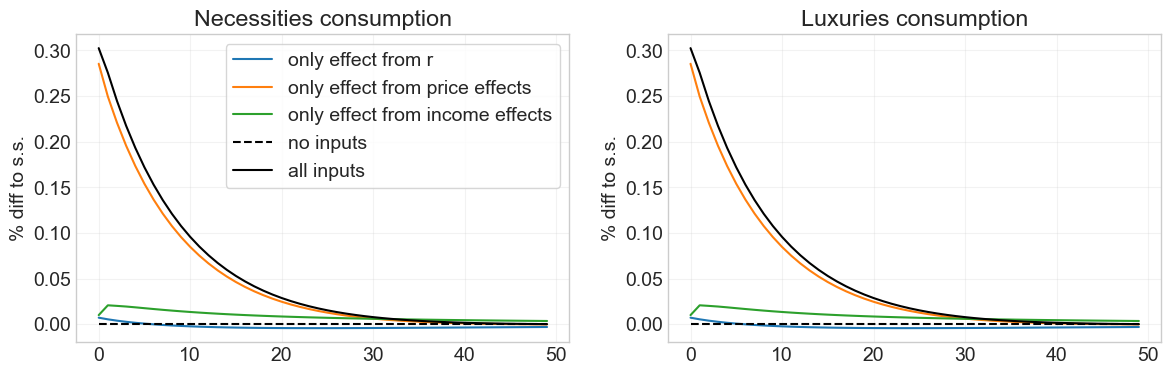

In [182]:
T_max = 50

fig = plt.figure(figsize=(14,4),dpi=100)

ax = fig.add_subplot(1,2,1)
i_color = 0
for use_inputs in [['r'],['price effects','Q','P','p_L','p_N'],['income effects','N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=False,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.P_hh[0,:50]/ss.P_hh-1)*100,ls=ls,color=color,label=label);
ax.set_title('Necessities consumption')    
ax.set_ylabel('% diff to s.s.')
ax.legend(frameon=True);

ax = fig.add_subplot(1,2,2)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=False,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.P_hh[0,:50]/ss.P_hh-1)*100,ls=ls,color=color,label=label);
ax.set_title('Luxuries consumption')        
ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True);

Behavior for a subset of households. Here those with zero assets contra max assets.

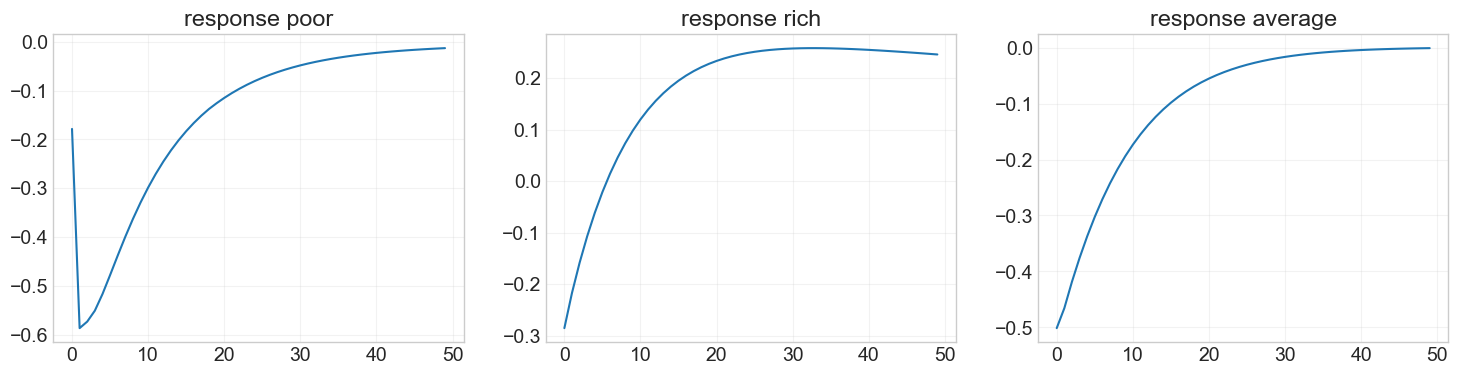

In [196]:
T_max = 50

fig = plt.figure(figsize=(3*6,4),dpi=100)
    
Dbeg = ss.Dbeg.copy()
Dbeg[:,:,1:] = 0.0 # zero every else than in first asset grid point
#Dbeg[:,:,:] = 0.0 # zero every else than in last 50 asset grid points
Dbeg /= np.sum(Dbeg) # re-normalize
path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
path_alt_poor = model.decompose_hh_path(Dbeg=Dbeg,use_inputs='all') 

ax = fig.add_subplot(1,3,1)
ax.set_title('response poor')
ax.plot((path_alt_poor.C_hh[0,:50]-path_alt_ss.C_hh[0,:50])/path_alt_ss.C_hh[0,:50]*100);

Dbeg = ss.Dbeg.copy()
Dbeg[:,:,:480] = 0.0 # zero every else than in last asset grid point
Dbeg /= np.sum(Dbeg) # re-normalize

path_alt_rich = model.decompose_hh_path(Dbeg=Dbeg,use_inputs='all') 
path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
ax = fig.add_subplot(1,3,2)
ax.set_title('response rich')
ax.plot((path_alt_rich.C_hh[0,:50]-path_alt_ss.C_hh[0,:50])/path_alt_ss.C_hh[0,:50]*100);


ax = fig.add_subplot(1,3,3)
ax.set_title('response average')
Dbeg = ss.Dbeg.copy() #reset dbeg value
path_alt_average = model.decompose_hh_path(Dbeg=Dbeg,use_inputs='all')
path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
ax.plot((path_alt_average.C_hh[0,:50]-path_alt_ss.C_hh[0,:50])/path_alt_ss.C_hh[0,:50]*100);

## Find transition path 2 - Monetary Policy shock

In [176]:
par.jump_istar = 0.0025 # 25 BP Monetary policy shock
par.jump_pm_N     = 0.0 # cost push shock
model.find_transition_path(do_print=False) #all

### shocks ###


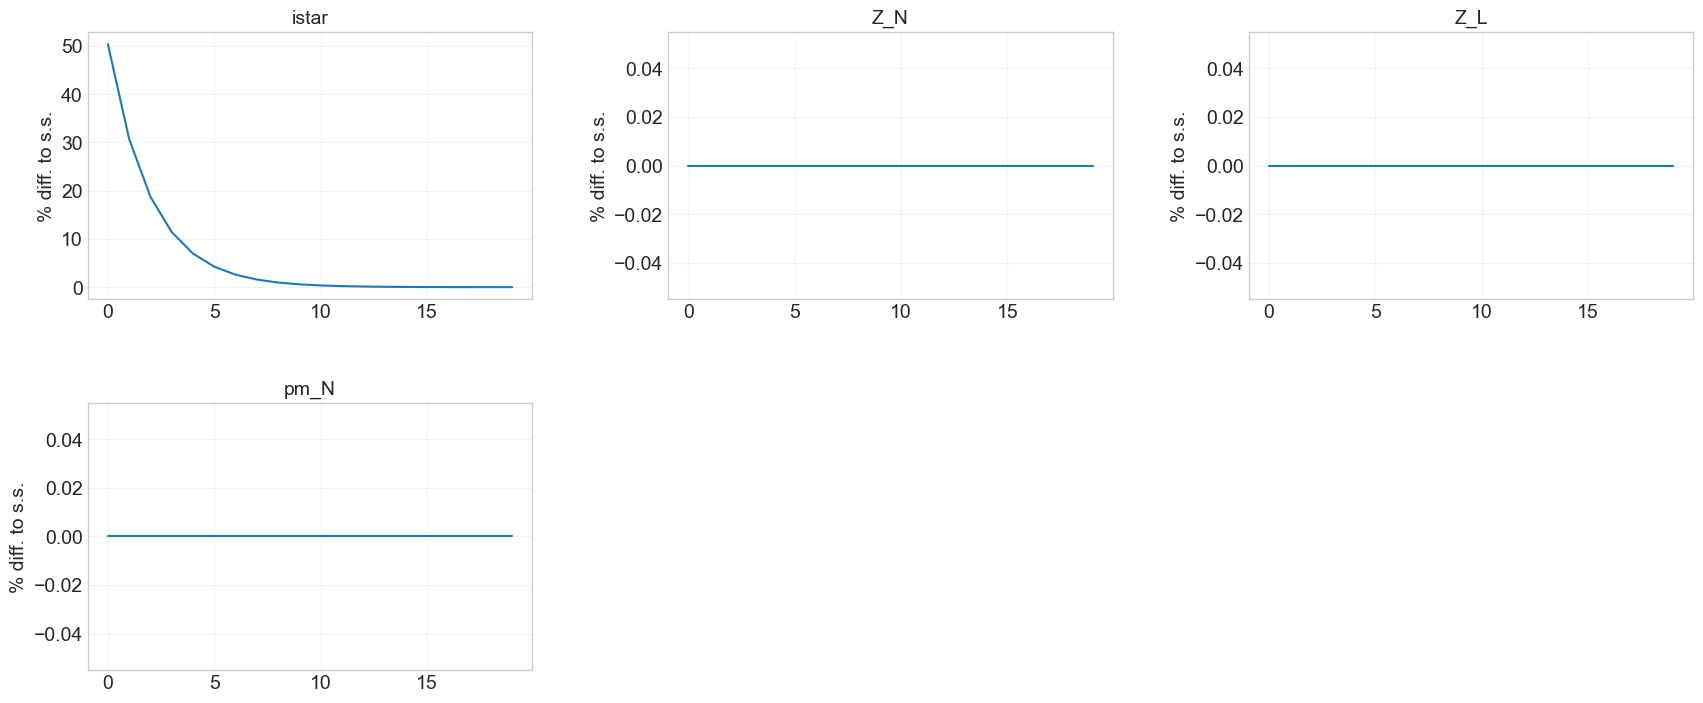


### varnames ###


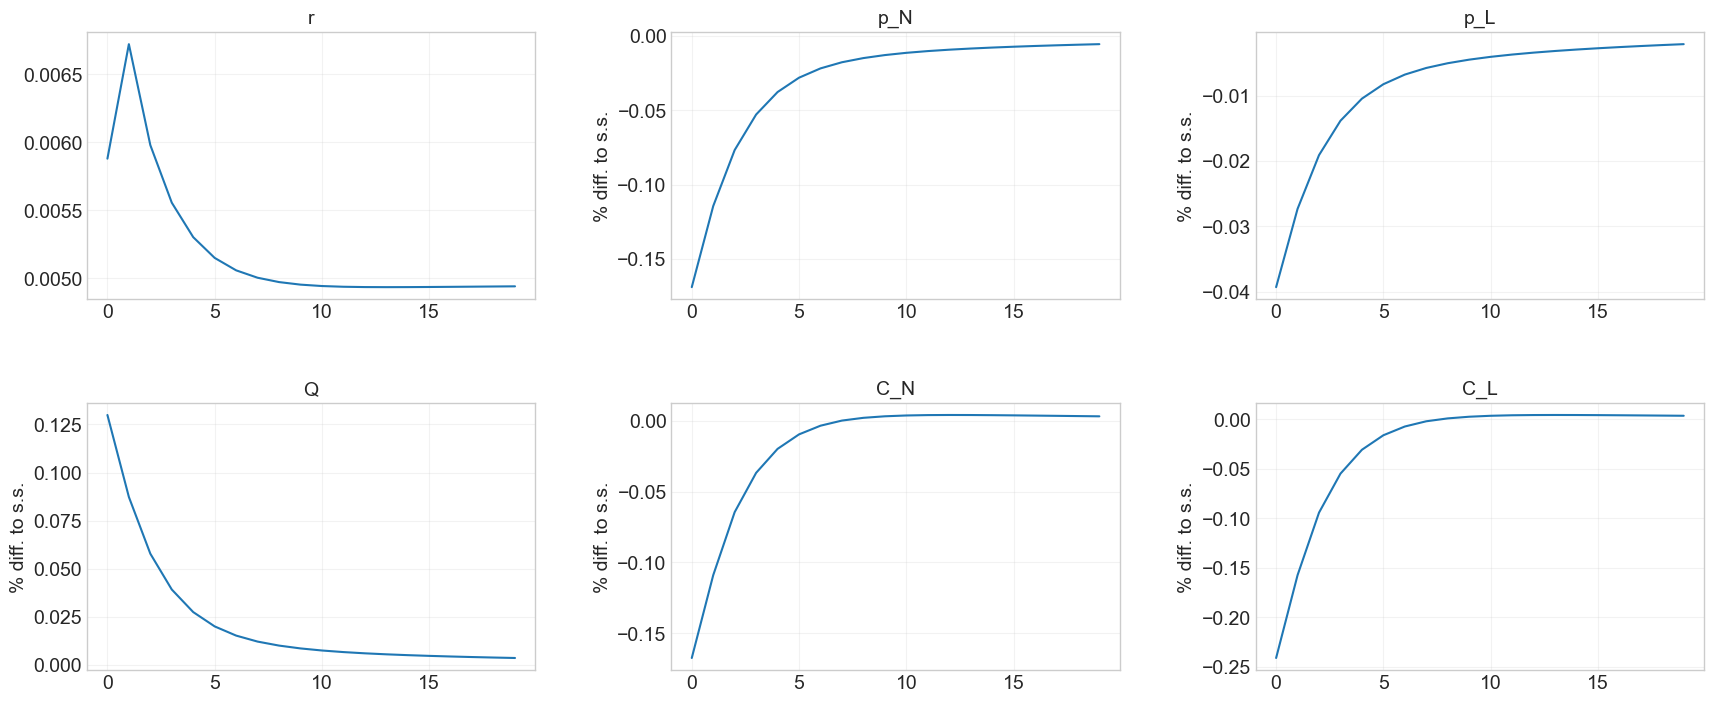


### tagets ###


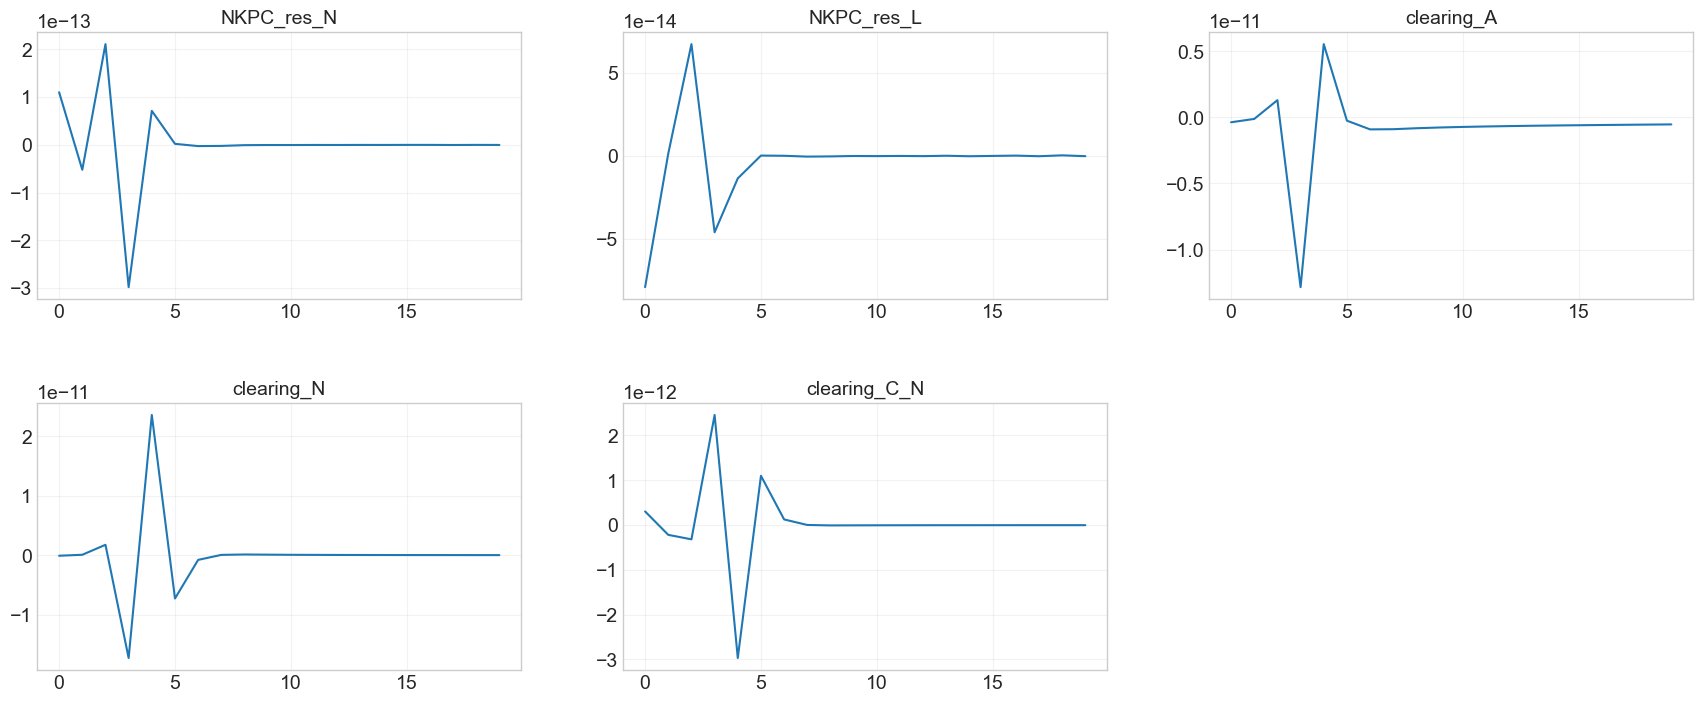

In [177]:
paths_main = ['r','p_N','p_L','Q','C_N','C_L'] #Show main
model.show_IRFs(paths_main,lvl_value=lvl_value,T_max=20,ncols=3)

### shocks ###


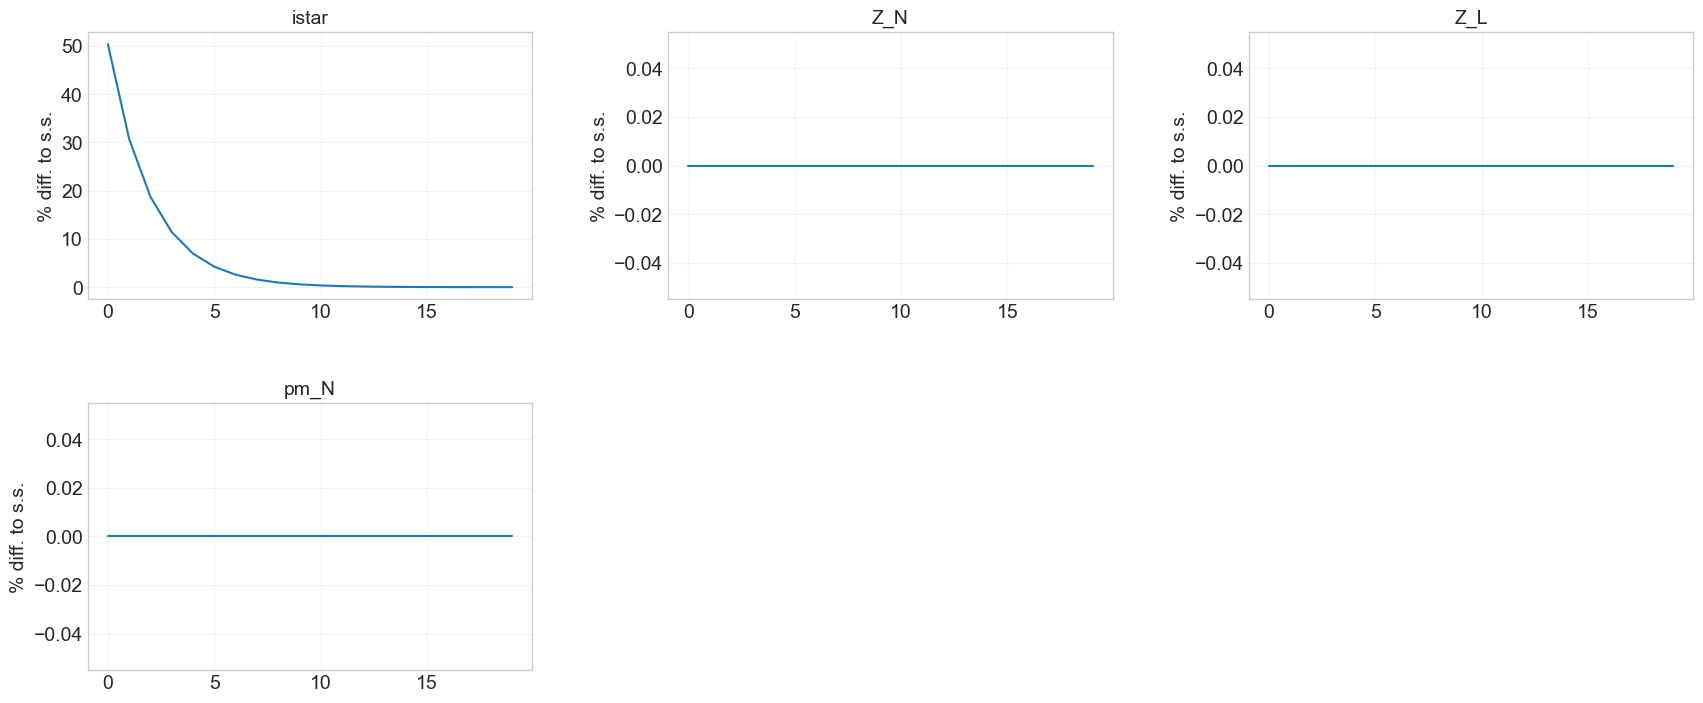


### varnames ###


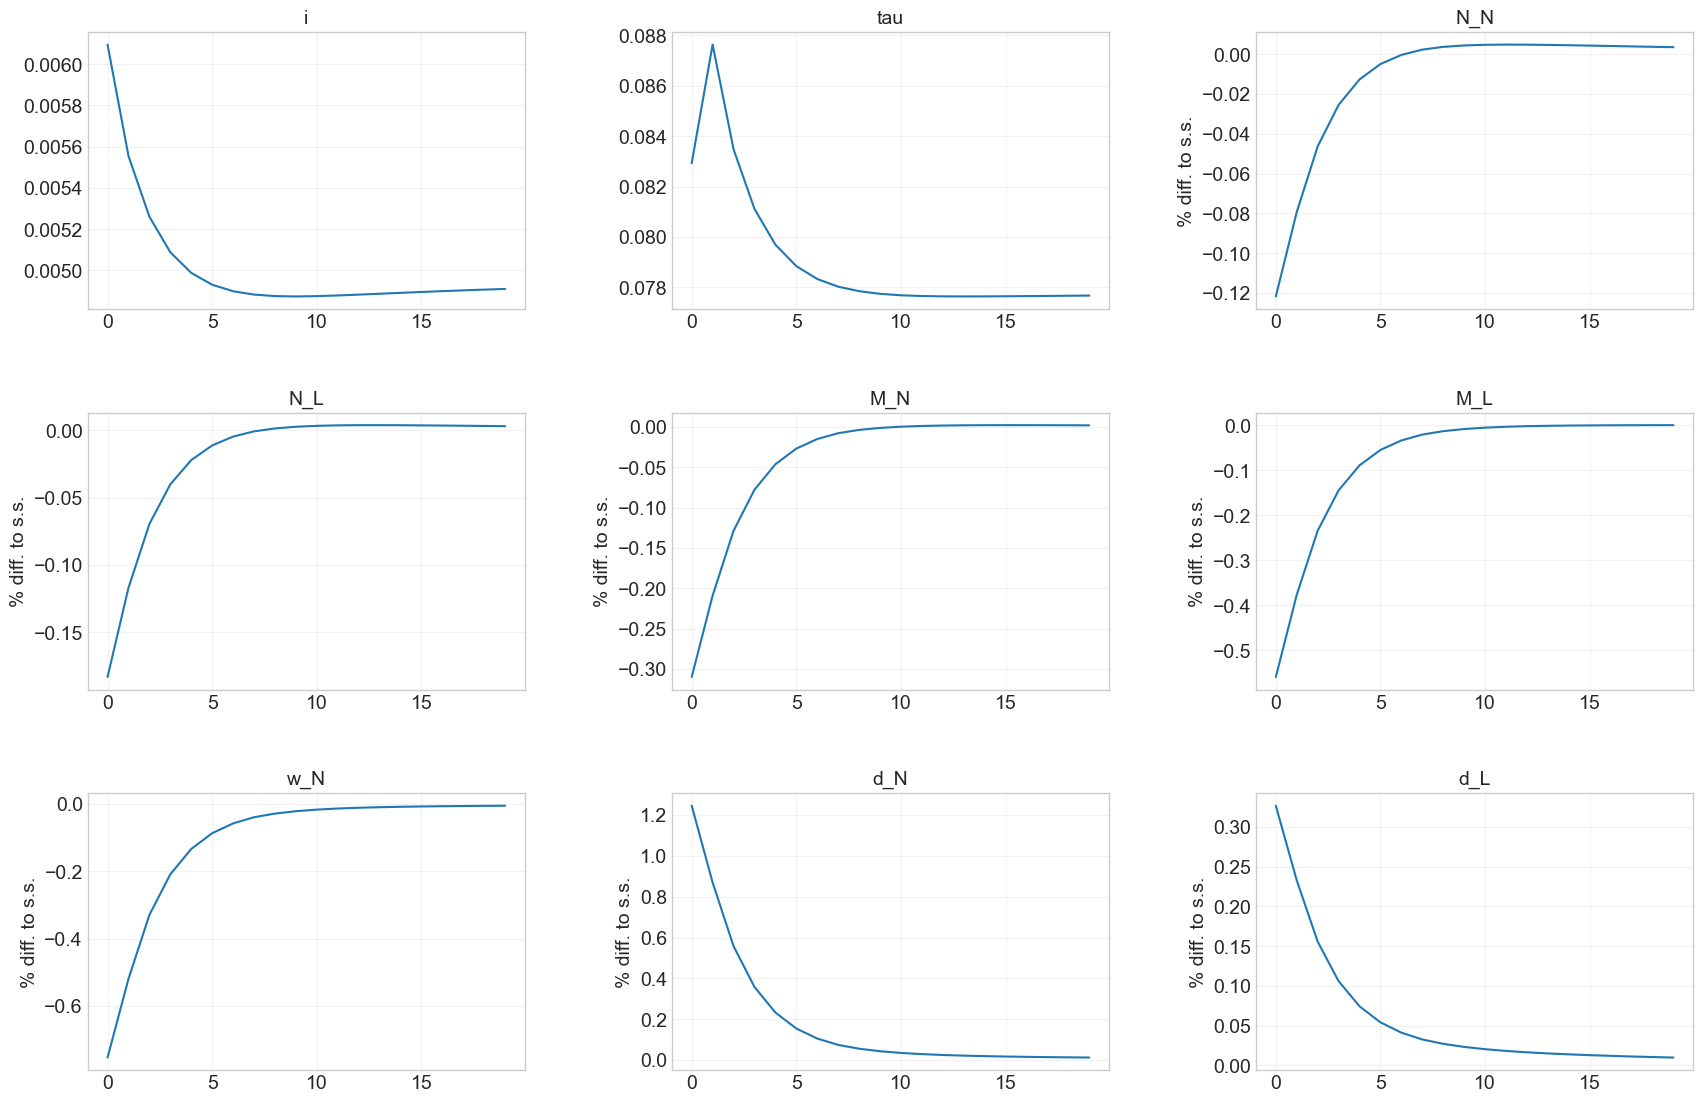


### tagets ###


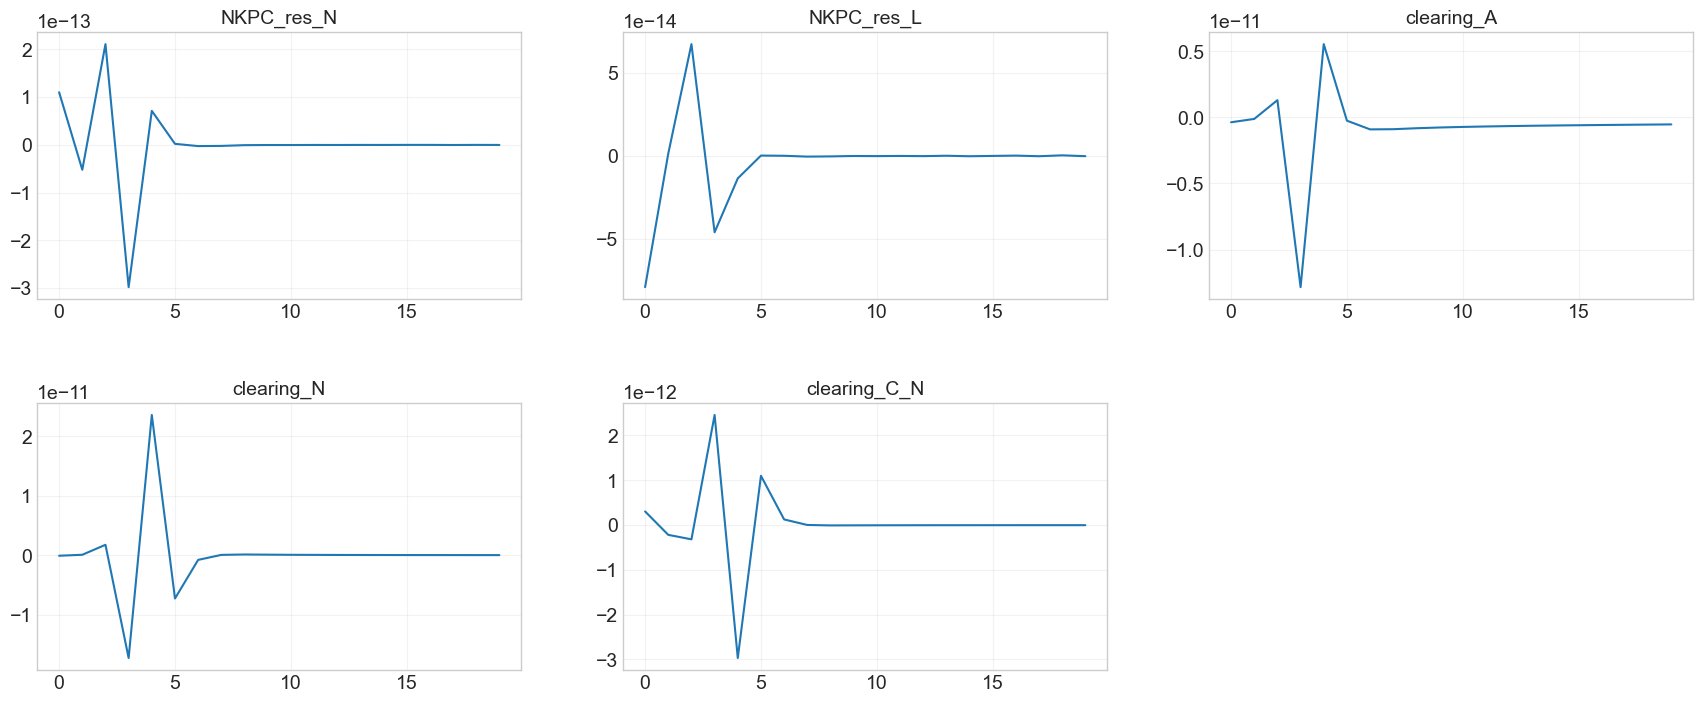

In [166]:
paths_appendix = ['i','tau','N_N','N_L','M_N','M_L','w_N','d_N','d_L'] #Show appendix
model.show_IRFs(paths_appendix,lvl_value=lvl_value,T_max=20,ncols=3)

Consumption decomposition, Monetary Policy Shock

['r']

['price effects', 'Q', 'P', 'p_L', 'p_N']

['income effects', 'N', 'w_N', 'd_N', 'd_L', 'tau']

None

all

['r']

['Q', 'P', 'p_L', 'p_N']

['N', 'w_N', 'd_N', 'd_L', 'tau']

None

all



Text(0, 0.5, '% diff to s.s.')

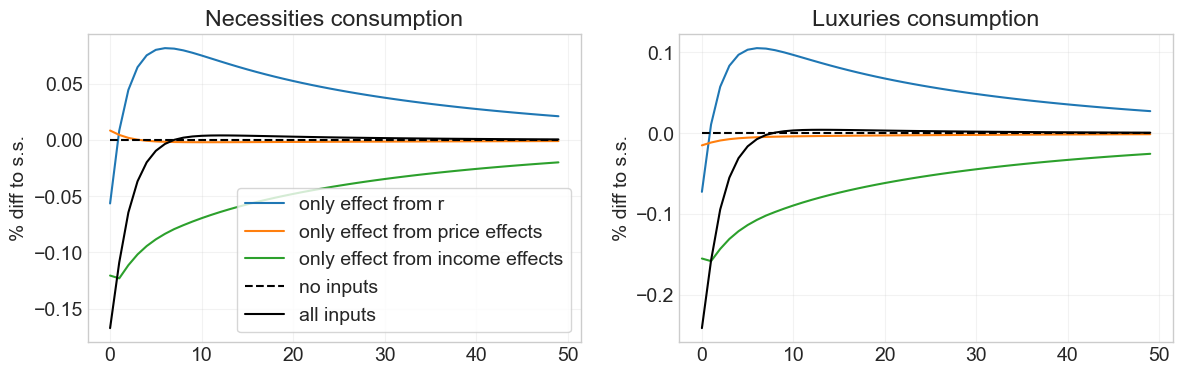

In [167]:
T_max = 50

fig = plt.figure(figsize=(14,4),dpi=100)

ax = fig.add_subplot(1,2,1)
i_color = 0
for use_inputs in [['r'],['price effects','Q','P','p_L','p_N'],['income effects','N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=False,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.C_N_hh[0,:50]/ss.C_N_hh-1)*100,ls=ls,color=color,label=label);
ax.set_title('Necessities consumption')    
ax.set_ylabel('% diff to s.s.')
ax.legend(frameon=True);

ax = fig.add_subplot(1,2,2)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=False,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.C_L_hh[0,:50]/ss.C_L_hh-1)*100,ls=ls,color=color,label=label);
ax.set_title('Luxuries consumption')        
ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True);

#ax = fig.add_subplot(1,3,3)
#i_color = 0
#for use_inputs in [['r'],['Q','P','p_L','p_N'],['w_N','d_N','d_L','tau'],None,'all']:
#    
#    # a. compute
#    print(use_inputs)
#    path_alt = model.decompose_hh_path(do_print=False,use_inputs=use_inputs)
#    print('')
#    
#    # b. plot
#    if use_inputs is None:
#        label = 'no inputs'
#        ls = '--'
#        color = 'black'
#    elif use_inputs == 'all':
#        label = 'all inputs'
#        ls = '-'
#        color = 'black'
#    else:
#        label = f'only effect from {use_inputs[0]}'
#        ls = '-'
#        color = colors[i_color]
#        i_color += 1
#        
#    ax.plot((path_alt.ELL_hh[0,:50]/ss.ELL_hh-1)*100,ls=ls,color=color,label=label);
#ax.set_title('labor supply')        
#ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True);


Behavior for a subset of households. Here those with zero assets.

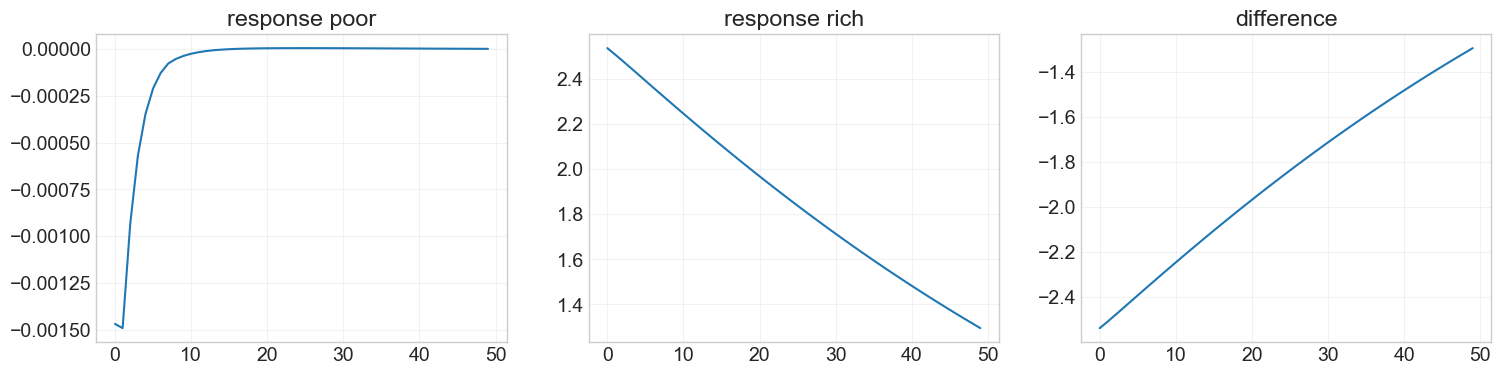

In [168]:
T_max = 50

fig = plt.figure(figsize=(3*6,4),dpi=100)
    
Dbeg = ss.Dbeg.copy()
Dbeg[:,:,1:] = 0.0 # zero every else than in first asset grid point
#Dbeg[:,:,:] = 0.0 # zero every else than in last 50 asset grid points
Dbeg /= np.sum(Dbeg) # re-normalize
path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
path_alt_poor = model.decompose_hh_path(Dbeg=Dbeg,use_inputs='all') 

ax = fig.add_subplot(1,3,1)
ax.set_title('response poor')
ax.plot(path_alt_poor.C_hh[0,:50]-path_alt_ss.C_hh[0,:50]);

Dbeg = ss.Dbeg.copy()
Dbeg[:,:,:480] = 0.0 # zero every else than in last asset grid point
Dbeg /= np.sum(Dbeg) # re-normalize

path_alt_rich = model.decompose_hh_path(Dbeg=Dbeg,use_inputs='all') 
ax = fig.add_subplot(1,3,2)
ax.set_title('response rich')
ax.plot(path_alt_rich.C_hh[0,:50]-path_alt_ss.C_hh[0,:50]);


ax = fig.add_subplot(1,3,3)
ax.set_title('difference')
ax.plot(path_alt_poor.C_hh[0,:50]-path_alt_rich.C_hh[0,:50]);
Dbeg = ss.Dbeg.copy() #reset dbeg value


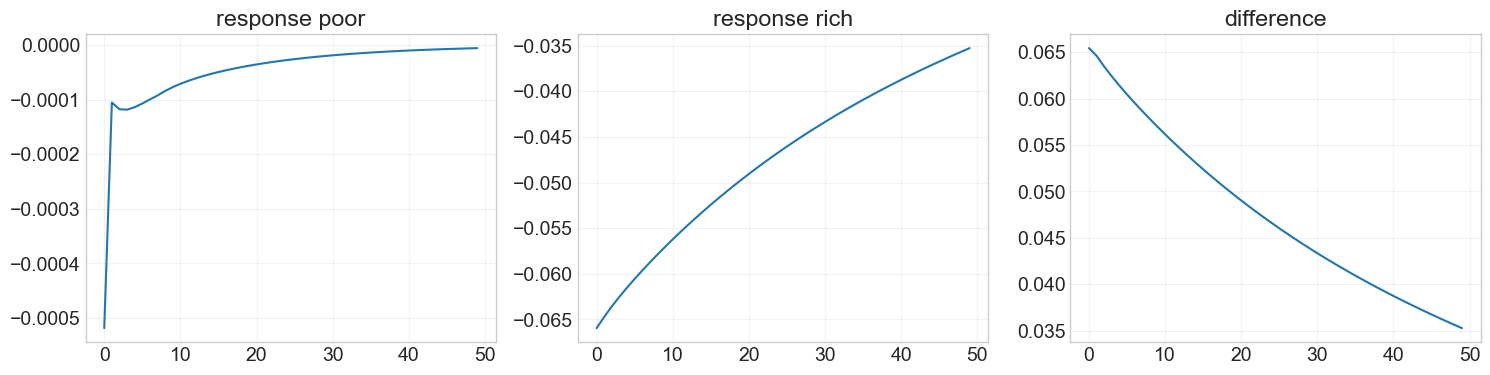

In [169]:
T_max = 50

fig = plt.figure(figsize=(3*6,4),dpi=100)
    
Dbeg = ss.Dbeg.copy()
Dbeg[:,:,1:] = 0.0 # zero every else than in first asset grid point
#Dbeg[:,:,:] = 0.0 # zero every else than in last 50 asset grid points
Dbeg /= np.sum(Dbeg) # re-normalize
path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
path_alt_poor = model.decompose_hh_path(Dbeg=Dbeg,use_inputs='all') 

ax = fig.add_subplot(1,3,1)
ax.set_title('response poor')
ax.plot(path_alt_poor.P_hh[0,:50]-path_alt_ss.P_hh[0,:50]);

Dbeg = ss.Dbeg.copy()
Dbeg[:,:,:480] = 0.0 # zero every else than in last asset grid point
Dbeg /= np.sum(Dbeg) # re-normalize

path_alt_rich = model.decompose_hh_path(Dbeg=Dbeg,use_inputs='all') 
ax = fig.add_subplot(1,3,2)
ax.set_title('response rich')
ax.plot(path_alt_rich.P_hh[0,:50]-path_alt_ss.P_hh[0,:50]);


ax = fig.add_subplot(1,3,3)
ax.set_title('difference')
ax.plot(path_alt_poor.P_hh[0,:50]-path_alt_rich.P_hh[0,:50]);
Dbeg = ss.Dbeg.copy() #reset dbeg value


## Find effect of parameter change

### varnames ###


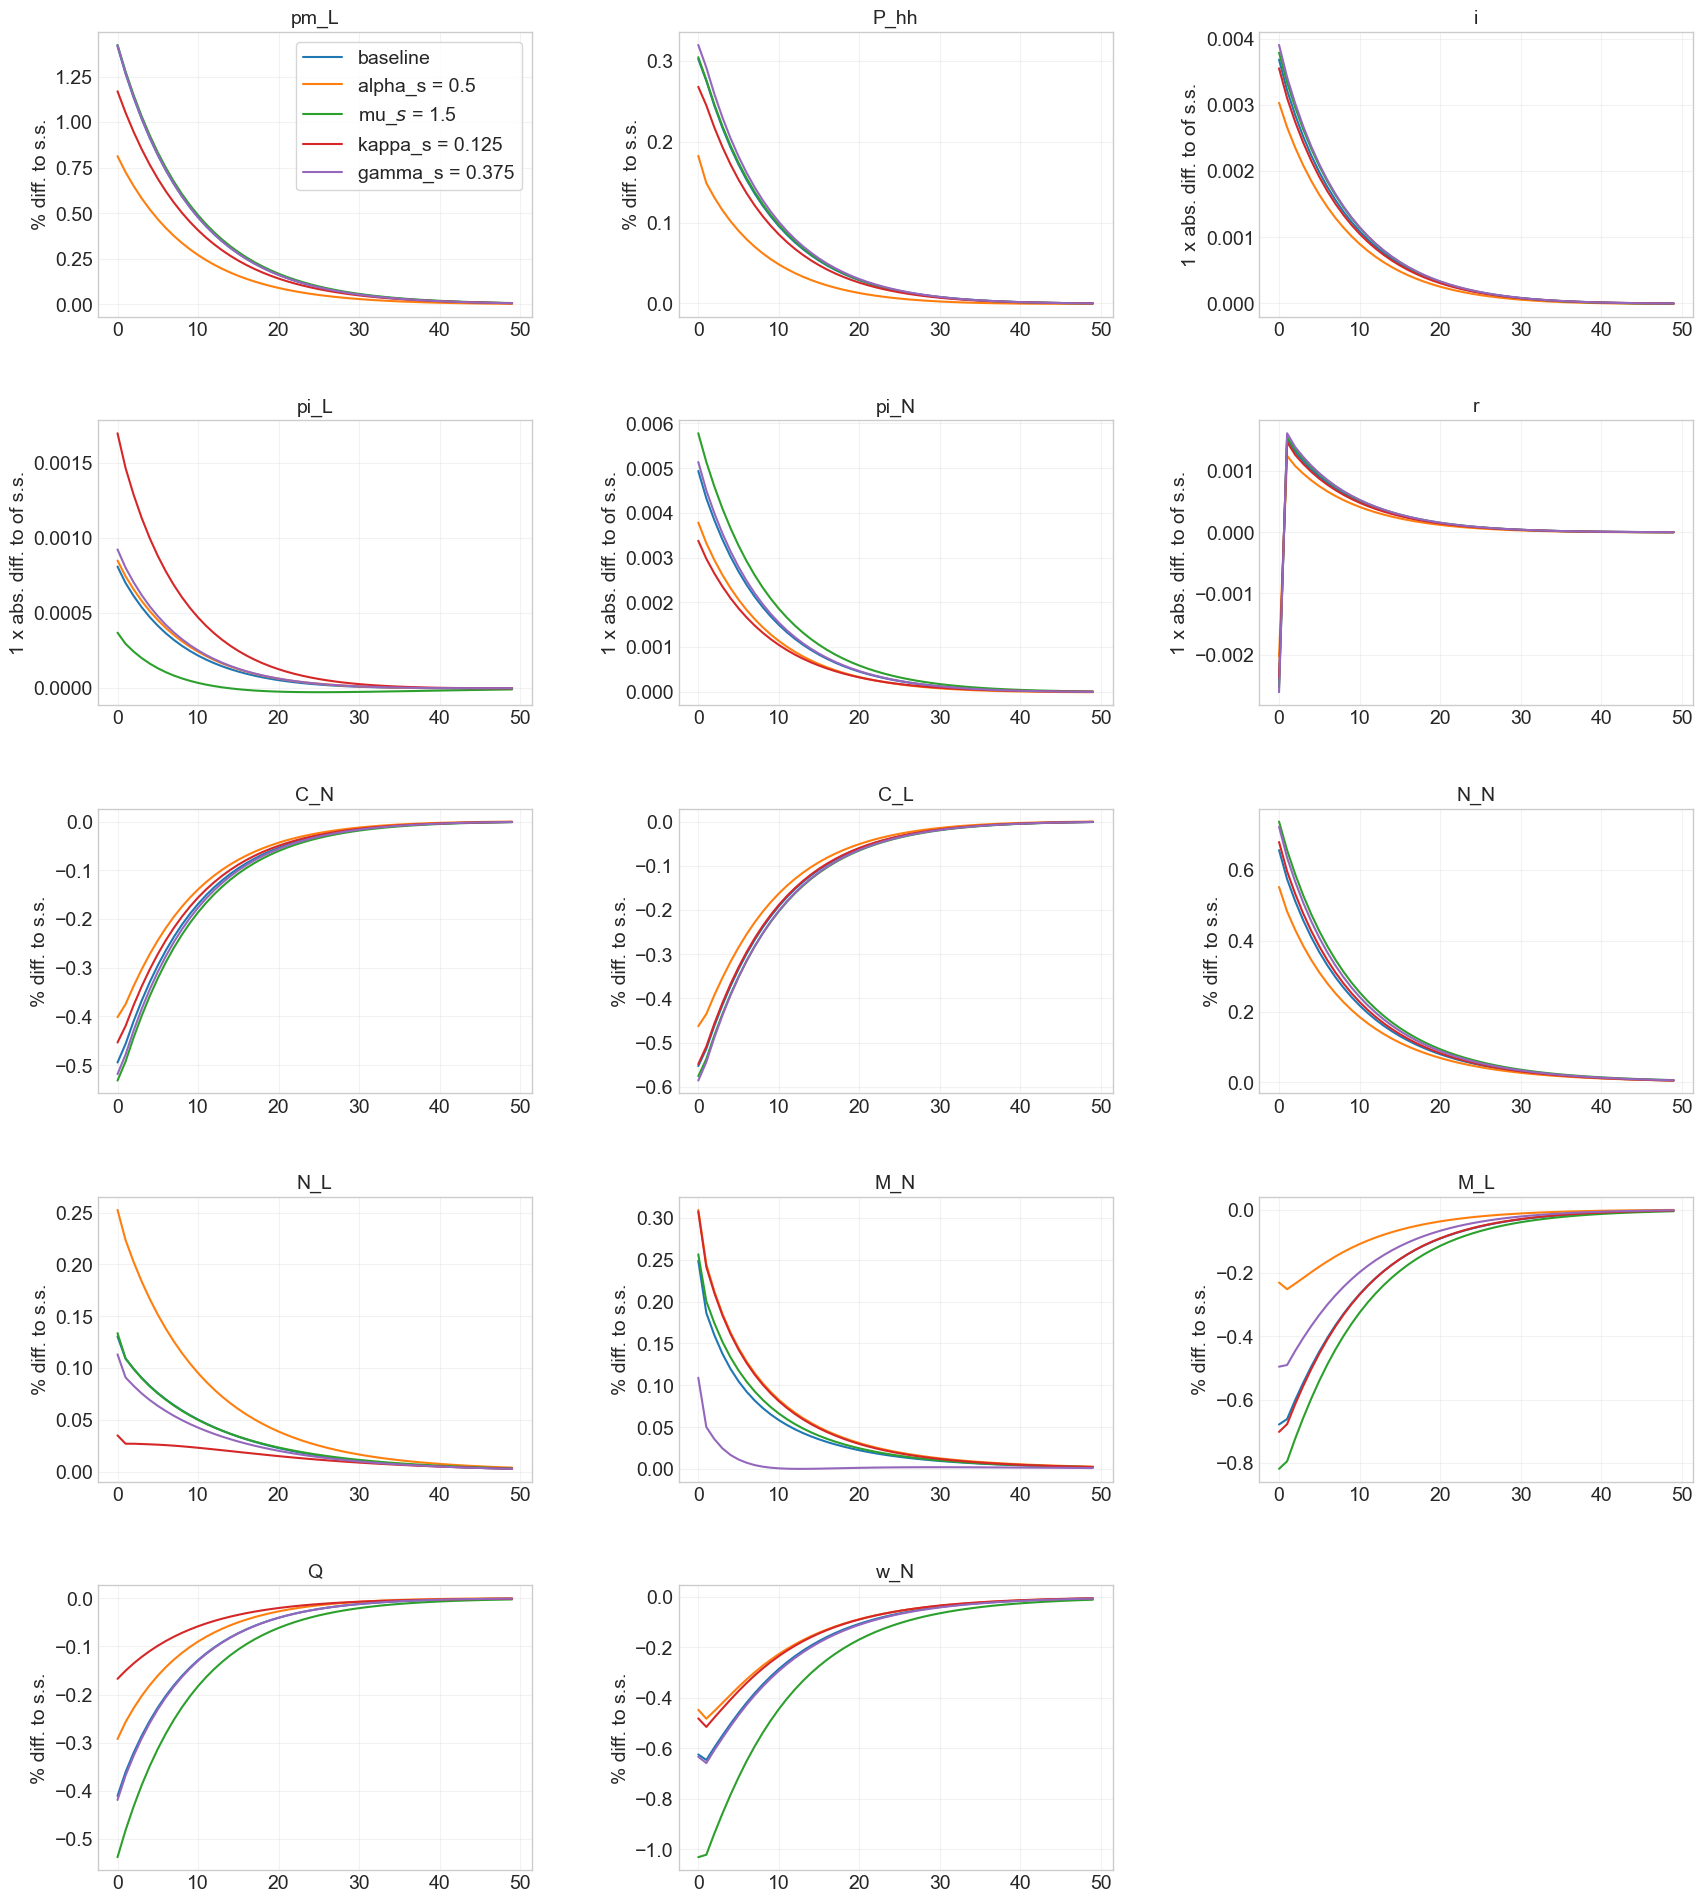

In [170]:
#Ensure baseline model has push shock
par.jump_istar = 0.00 # Monetary policy shock reset
par.jump_pm_N     = 0.01*ss.Q # cost push shock
model.find_transition_path(do_print=False) #all

#CD loading checks
model_one = model.copy()
model_one.par.alpha_N = 0.5
model_one.par.alpha_L = 0.5
model_one.par.jump_pm_N     = 0.01*ss.Q # cost push shock
#model_two.par.jump_istar = 0.0025 # Monetary policy shock reset
model_one.find_ss()
model_one.compute_jacs()
model_one.find_transition_path()

#Mark-up checks
model_two = model.copy()
model_two.par.mu_L = 1.5
model_two.par.mu_N = 1.5
model_two.par.jump_pm_N     = 0.01*ss.Q # cost push shock
#model_two.par.jump_istar = 0.0025 # Monetary policy shock reset
model_two.find_ss()
model_two.compute_jacs()
model_two.find_transition_path()

#Price rigidity checks
model_three = model.copy()
model_three.par.kappa_L = 0.125
model_three.par.kappa_N = 0.125
model_three.par.jump_pm_N     = 0.01*ss.Q # cost push shock
#model_three.par.jump_istar = 0.0025 # Monetary policy shock reset
model_three.find_ss()
model_three.compute_jacs()
model_three.find_transition_path()

#Substitution elasticities check
model_four = model.copy()
model_four.par.gamma_L = 0.375
model_four.par.gamma_N = 0.375
model_four.par.jump_pm_N     = 0.01*ss.Q # cost push shock
#model_four.par.jump_istar = 0.0025 # Monetary policy shock reset
model_four.find_ss()
model_four.compute_jacs()
model_four.find_transition_path()


paths = ['pm_L','P_hh','i','pi_L','pi_N','r','C_N','C_L','N_N','N_L','M_N','M_L','Q','w_N'] #Show all graphs
model.compare_IRFs([model,model_one,model_two,model_three,model_four],['baseline','alpha_s = 0.5','mu_$s$ = 1.5','kappa_s = 0.125','gamma_s = 0.375'],paths,lvl_value,do_shocks=False,do_targets=False,T_max=50,ncols=3)

# Step 3b: Find linearized IRFs

In [171]:
model.find_IRFs(do_print=True)

linear transition path found in 1.5 secs [finding solution matrix: 1.1 secs]


### shocks ###


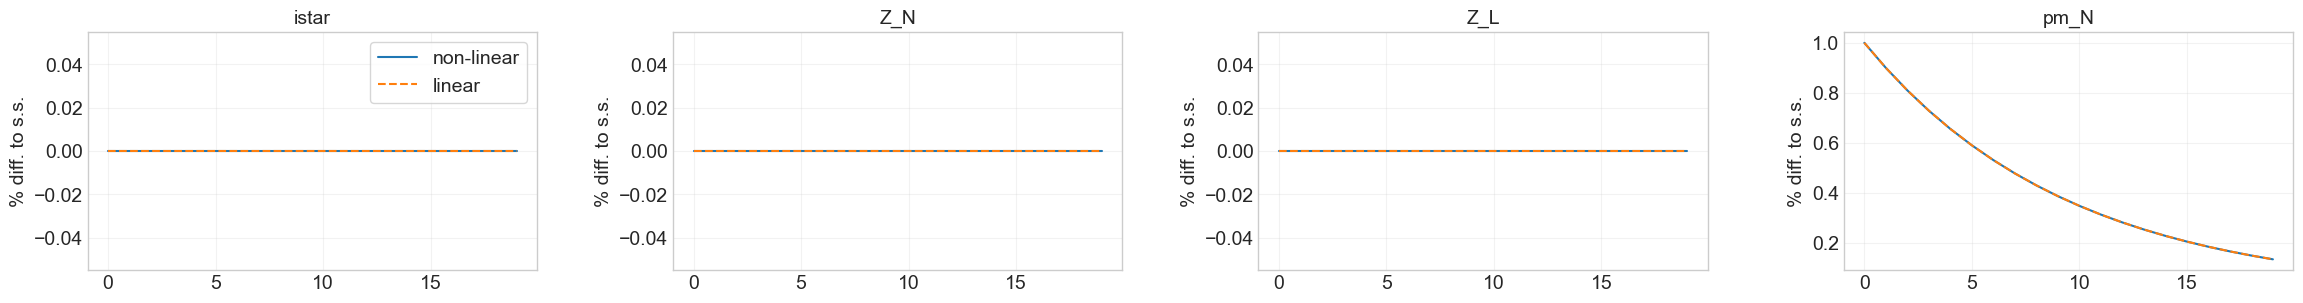


### varnames ###


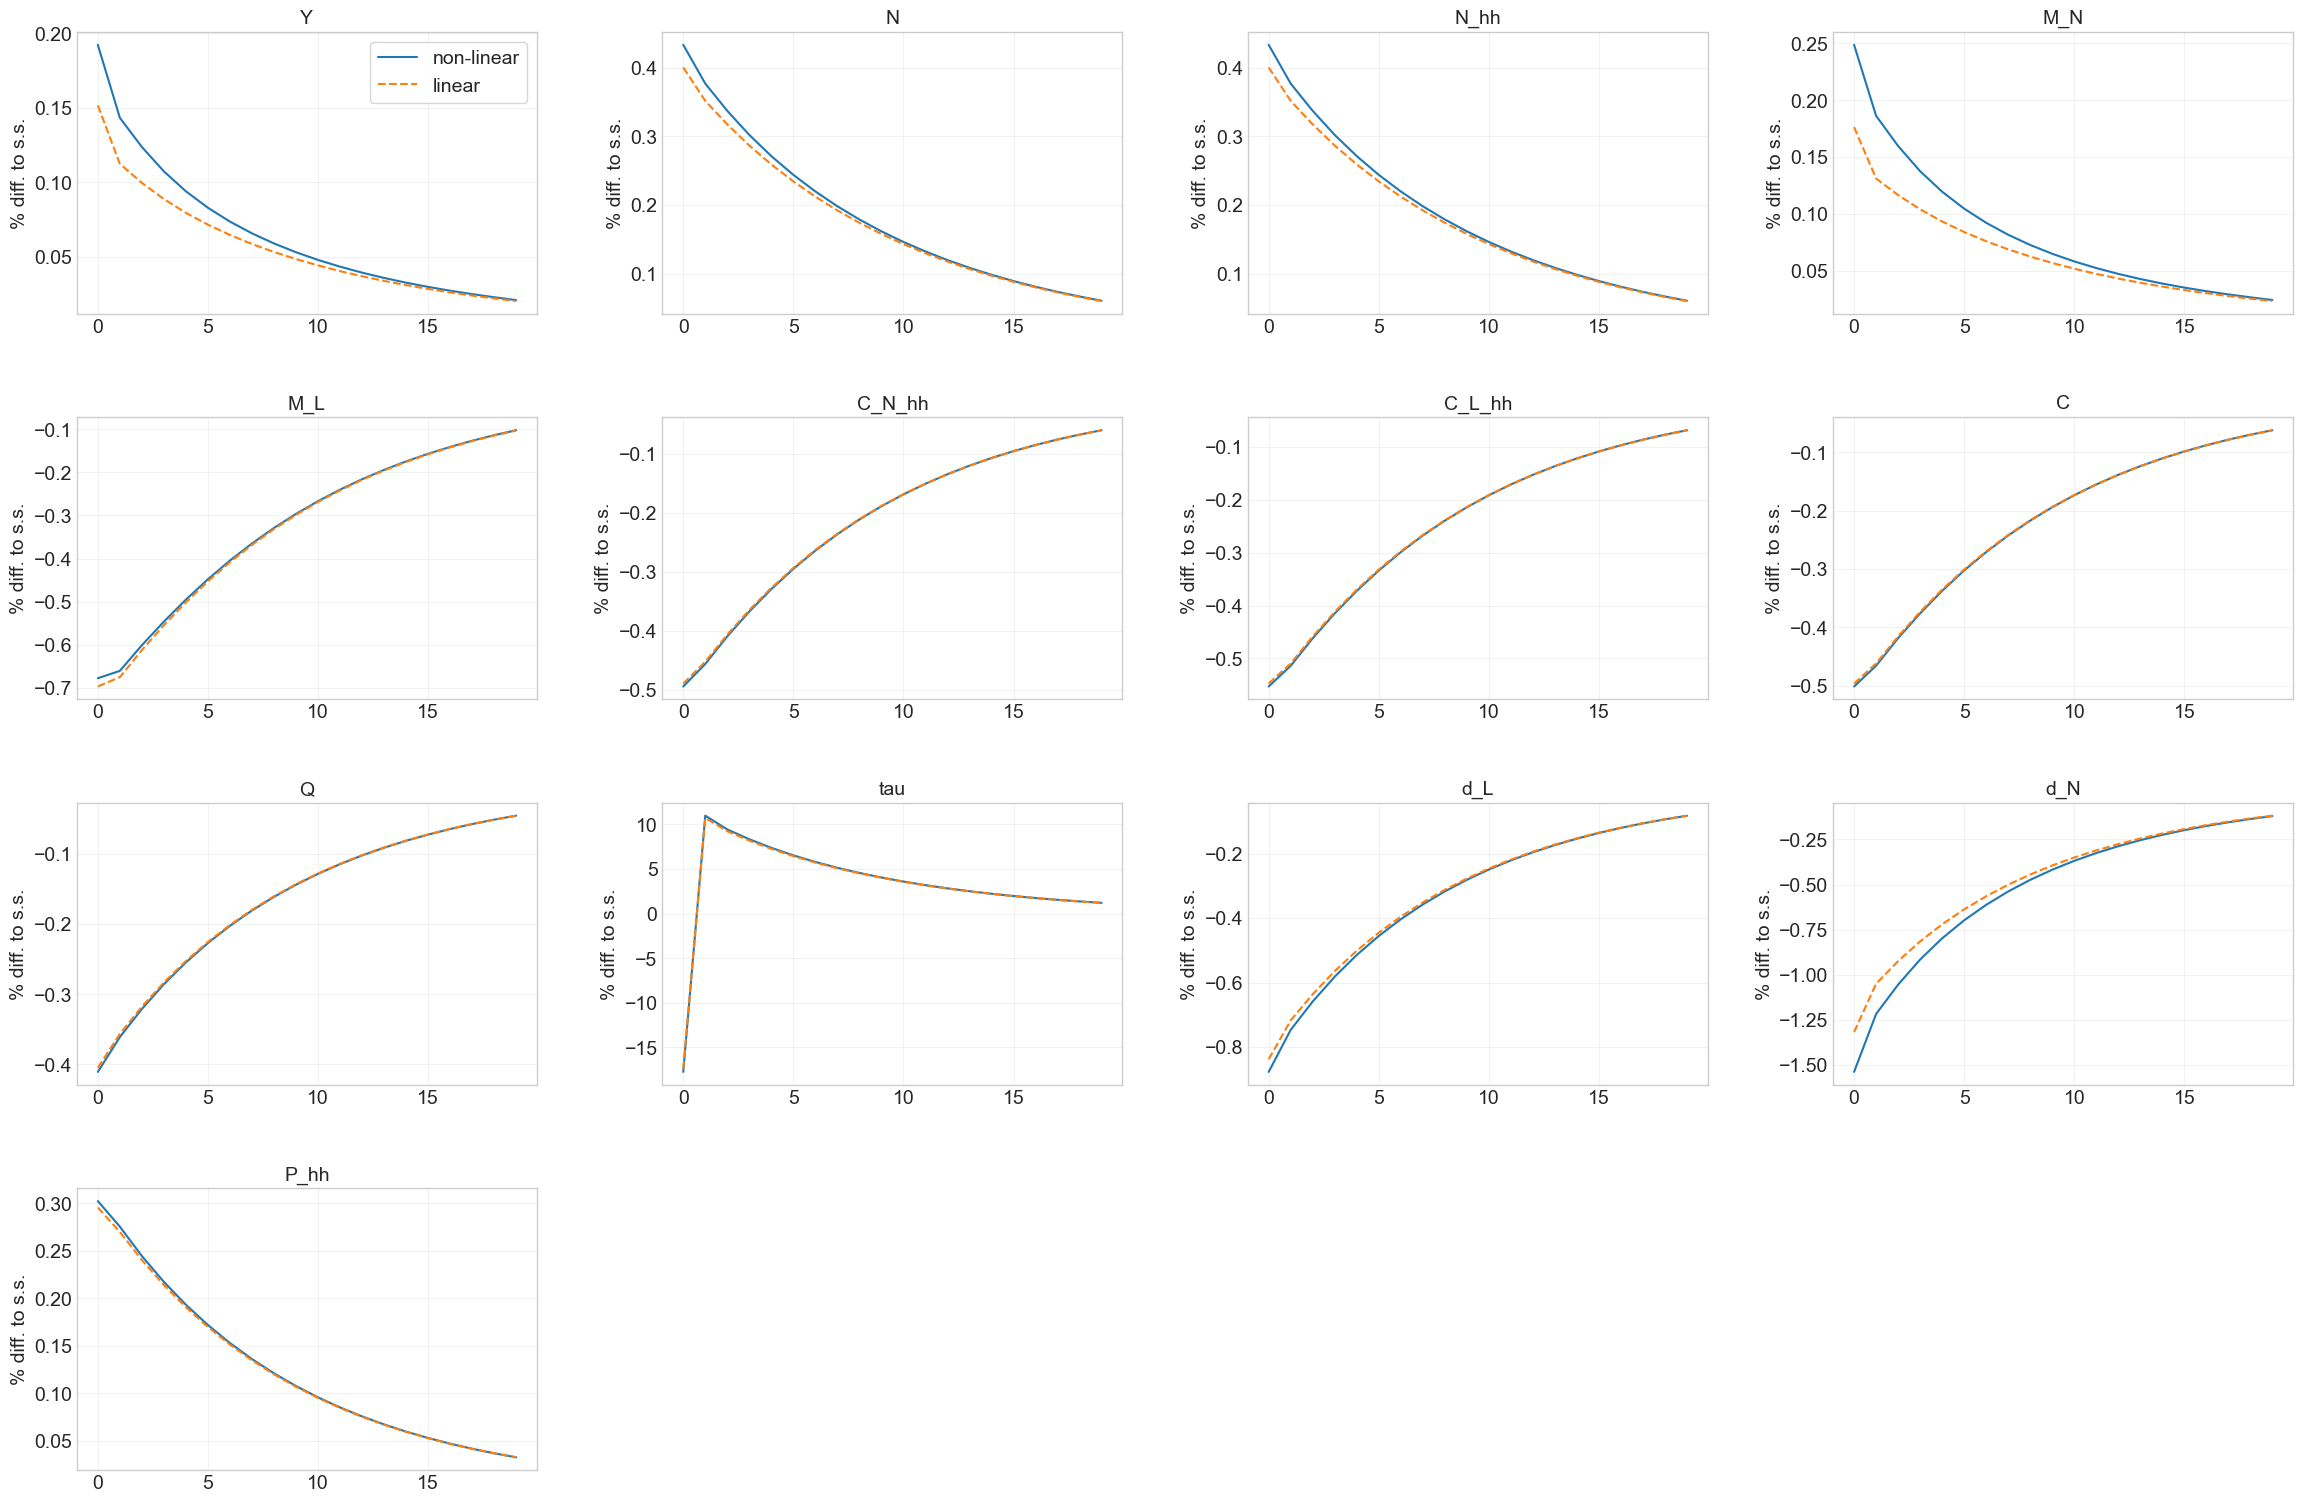


### tagets ###


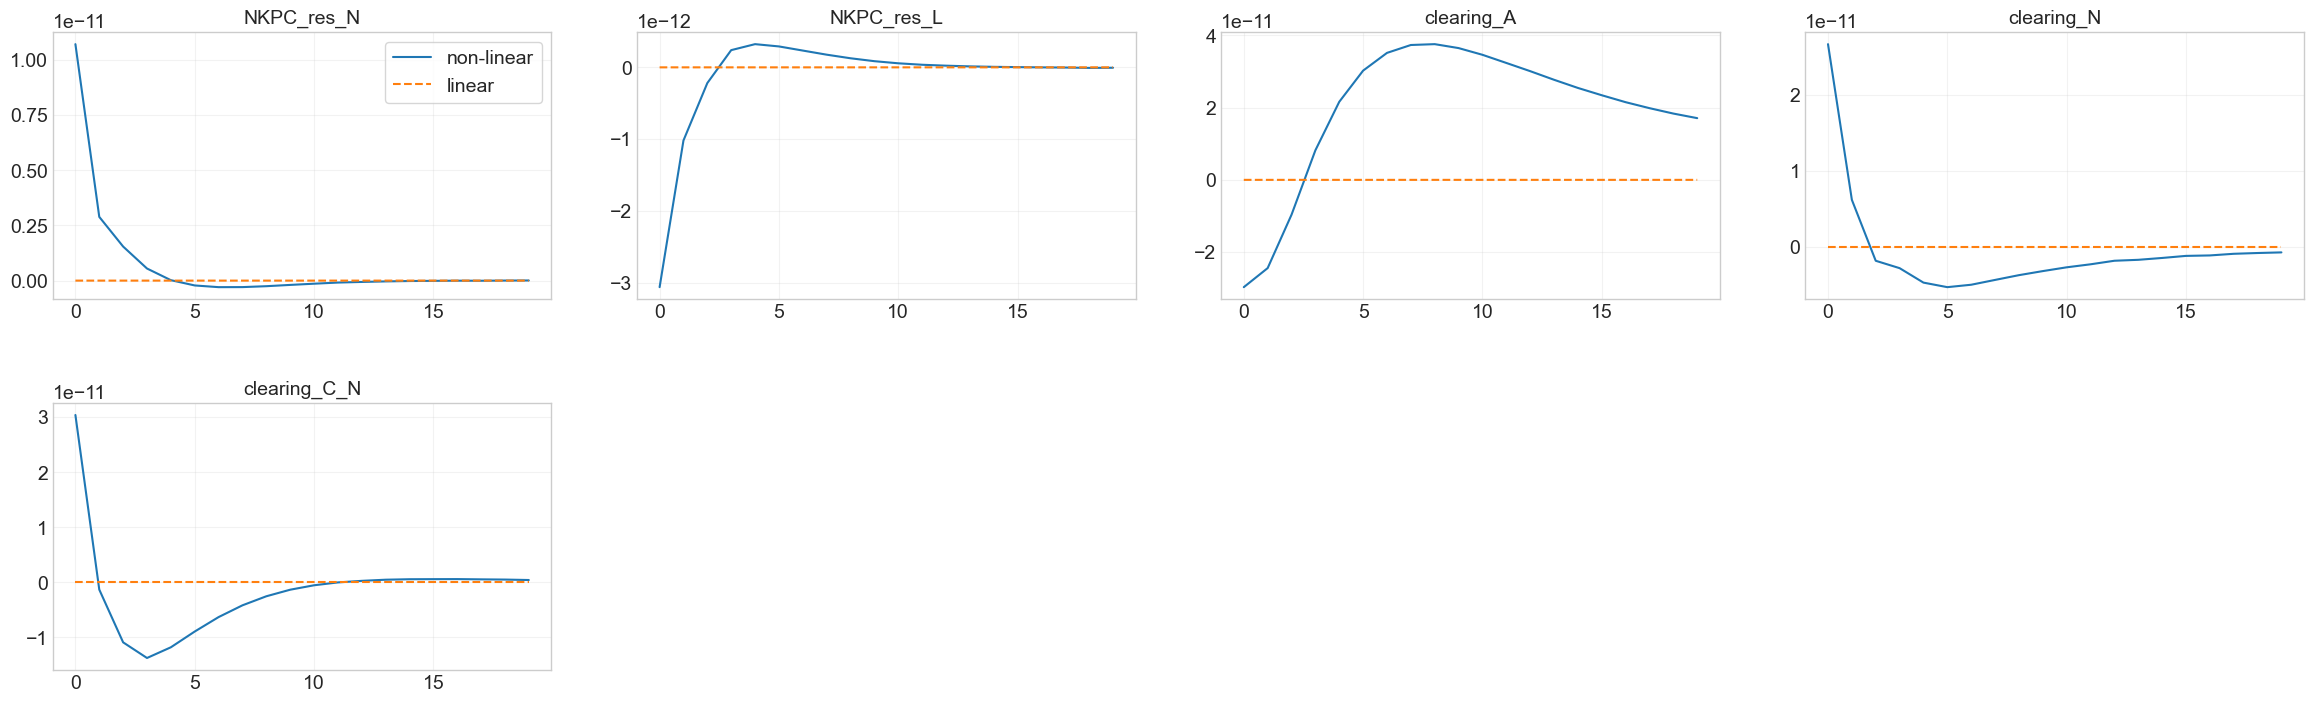

In [172]:
paths = ['Y','N','N_hh','M_N','M_L','C_N_hh','C_L_hh','C','Q','tau','d_L','d_N','P_hh']
model.show_IRFs(paths,T_max=20,ncols=4,do_linear=True)

# Step 4. Simulation

In [173]:
#np.random.seed(1917)
#model.simulate(do_print=True)

In [174]:
#def model_sim():
#    
#    fig = plt.figure(figsize=(12,8),dpi=100)
#
#    ax = fig.add_subplot(2,2,1)
#    ax.set_title('i')
#    ax.plot(ss.i+sim.di,ls='--')
#    ax.axhline(ss.i,color='black',zorder=0)
#
#    ax = fig.add_subplot(2,2,2)
#    ax.set_title('pi')
#    ax.plot(ss.pi+sim.dpi,ls='--',)
#    ax.axhline(ss.pi,color='black',zorder=0)
#    
#    ax = fig.add_subplot(2,2,3)
#    ax.set_title('r')
#    ax.plot(ss.r+sim.dr,ls='--',)
#    ax.axhline(ss.r,color='black',zorder=0)
#    
#    ax = fig.add_subplot(2,2,4)
#    ax.set_title('C')
#    ax.plot(ss.C+sim.dC,ls='--',)
#    ax.axhline(ss.C,color='black',zorder=0)
    

In [175]:
#model_sim()